# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from matplotlib.dates import MonthLocator, DateFormatter
from dataclasses import dataclass
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
import os

# Importing data

In [2]:
path = '1. Preprocessing/'
df = pd.read_csv(path + 'Preprocessed_df.csv' , parse_dates=['Date'])
tf.random.set_seed(3) 

cols_dtype = df.columns.drop('Date')
df[cols_dtype] = df[cols_dtype].astype(int)

print(df.shape)
df.head()

(533, 7)


Date  ActiveCustomer  Churned  DealsAdded  Leads  NewPaid  ClosedDeals
0 2022-03-21            1183        0        3565     19        1         1196
1 2022-03-22            1097        2         774     20        1          478
2 2022-03-23             946        0         997     20        1          458
3 2022-03-24             918        0         590     19        0          370
4 2022-03-25             857        5         498     17        0          282

# Train-Test Split

In [3]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    WINDOW_SIZE = 50 # values such as 60 and 90 should be checked
    BATCH_SIZE = 44 # other values should be checked
    SHUFFLE_BUFFER_SIZE = 1000

In [4]:
def plot_time_series(dates, series_data, series_labels=None, title=None):
    plt.style.use('seaborn')
    plt.figure(figsize=(20, 5), dpi=200)

    if series_labels is None:
        series_labels = [f'Series {i + 1}' for i in range(len(series_data))]

    if isinstance(series_data, tuple):
        for series, label in zip(series_data, series_labels):
            plt.plot(dates, series, label=label)
    else:
        plt.plot(dates, series_data, label=series_labels[0])

    # Customize the subplot
    min_y = np.min(series_data)
    max_y = np.max(series_data)
    
    plt.title(f'Time Series Trend {title}', fontsize=14)
    plt.tick_params(axis='both', labelsize=10)
    plt.xlim([dates.min(), dates.max()])  # Specify the x-axis limits
    plt.ylim([min_y-100 , max_y+100])  # Set the y-axis limit to the desired value
    plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))  # Format the month and year
    plt.legend()  # Add legend for series labels
    plt.tight_layout()
    plt.show()

In [5]:
df.head()

Date  ActiveCustomer  Churned  DealsAdded  Leads  NewPaid  ClosedDeals
0 2022-03-21            1183        0        3565     19        1         1196
1 2022-03-22            1097        2         774     20        1          478
2 2022-03-23             946        0         997     20        1          458
3 2022-03-24             918        0         590     19        0          370
4 2022-03-25             857        5         498     17        0          282

In [6]:
split_train = round(0.6*df.shape[0])
split_val = round(0.8*df.shape[0])

time_train = df.loc[:split_train , 'Date']
time_val = df.loc[split_train+1:split_val , 'Date']
time_test = df.loc[split_val+1: , 'Date']

In [7]:
len(time_train), len(time_val), len(time_test)

(321, 106, 106)

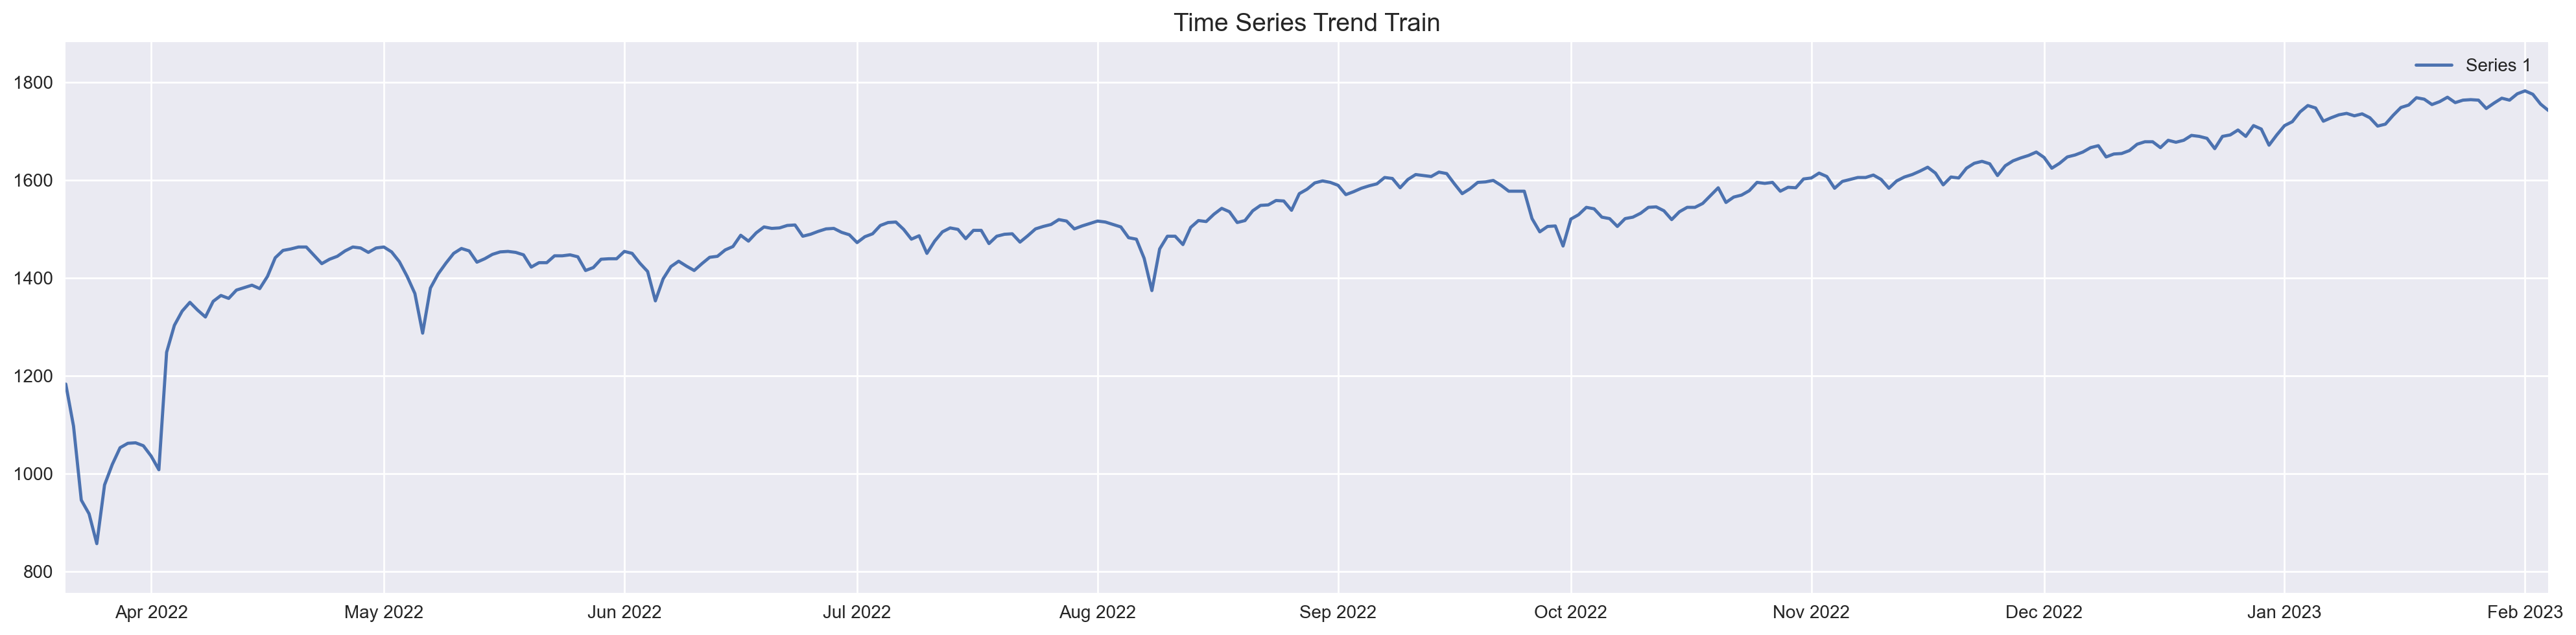

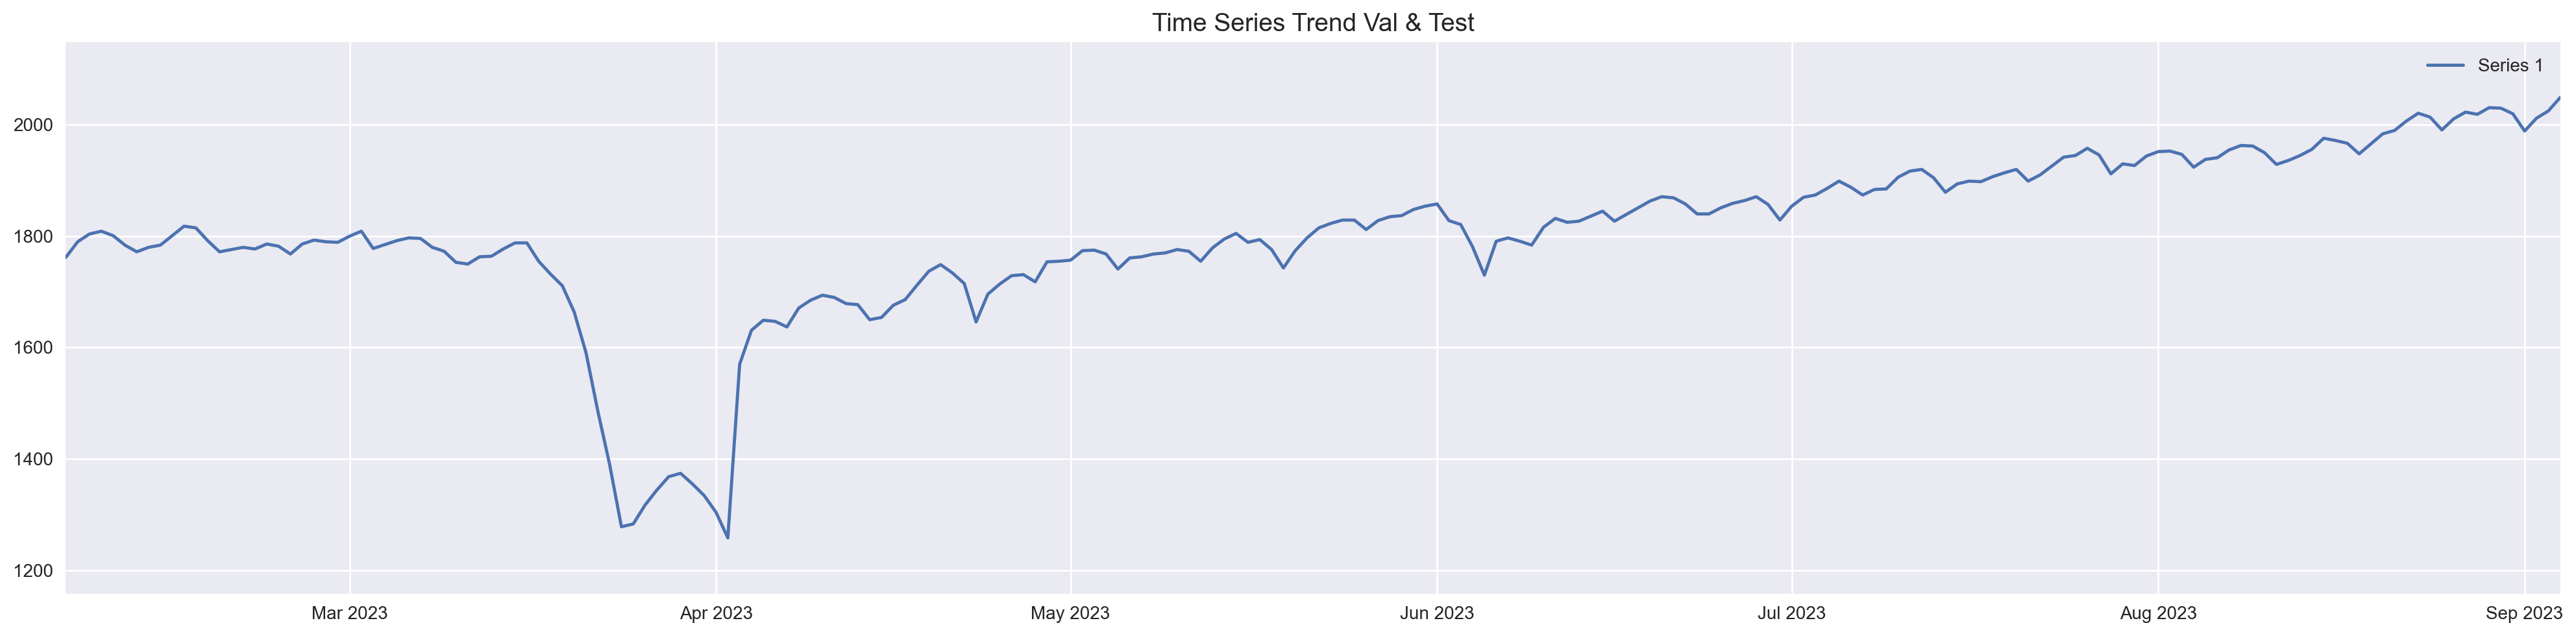

In [8]:
plot_time_series(time_train, df.loc[:split_train , 'ActiveCustomer'] , title = 'Train')
plot_time_series(df.loc[split_train+1: , 'Date'], df.loc[split_train+1: , 'ActiveCustomer'], title = 'Val & Test')

In [9]:
x_train, x_val, x_test =  df.loc[:split_train] , df.iloc[split_train - G.WINDOW_SIZE + 1:split_val], df.iloc[split_val - G.WINDOW_SIZE + 1:]

Baseline Error

In [10]:
print(tf.keras.metrics.mean_absolute_error(df.loc[split_val: , 'ActiveCustomer'], df.loc[split_val-1:df.shape[0]-2 , 'ActiveCustomer']).numpy())

13


# Preprocessing Function

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Univariate Models

In [12]:
x_train_univariate = x_train['ActiveCustomer']
x_val_univariate = x_val['ActiveCustomer']
x_test_univariate = x_test['ActiveCustomer']

In [13]:
df

Date  ActiveCustomer  Churned  DealsAdded  Leads  NewPaid  \
0   2022-03-21            1183        0        3565     19        1   
1   2022-03-22            1097        2         774     20        1   
2   2022-03-23             946        0         997     20        1   
3   2022-03-24             918        0         590     19        0   
4   2022-03-25             857        5         498     17        0   
..         ...             ...      ...         ...    ...      ...   
528 2023-08-31            2020        6        7171     22        2   
529 2023-09-01            1989        3        2399     25        1   
530 2023-09-02            2012        3       15379     43        7   
531 2023-09-03            2025        6       14102     36        3   
532 2023-09-04            2049        5       13189     47        6   

     ClosedDeals  
0           1196  
1            478  
2            458  
3            370  
4            282  
..           ...  
528         4562  
529          699  
530         8800  
531         8796  
532         8597  

[533 rows x 7 columns]

In [14]:
# Generate the dataset windows
scaler = MinMaxScaler()
x_train_univariate = x_train['ActiveCustomer'].to_numpy().reshape(-1, 1)
x_train_univariate = scaler.fit_transform(x_train_univariate).squeeze()
print(len(x_train_univariate))

x_val_univariate = x_val['ActiveCustomer'].to_numpy().reshape(-1, 1)
x_val_univariate = scaler.transform(x_val_univariate).squeeze()
print(len(x_val_univariate))

x_test_univariate = x_test['ActiveCustomer'].to_numpy().reshape(-1, 1)
x_test_univariate = scaler.transform(x_test_univariate).squeeze()
x_test_univariate_inversed = scaler.inverse_transform(x_test_univariate.reshape(-1,1)).squeeze()

print(len(x_test_univariate))

x_train_univariate = windowed_dataset(x_train_univariate, G.WINDOW_SIZE, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE)
x_val_univariate = windowed_dataset(x_val_univariate, G.WINDOW_SIZE, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE)
# x_test_univariate = windowed_dataset(x_test_univariate, G.WINDOW_SIZE, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE)
x_train_univariate

321
155
156


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [15]:
# creating validation set for prediciton again 
# (this time the windowing is done in the model_forecast function)

x_val_univariate_forecast = x_val['ActiveCustomer'].to_numpy().reshape(-1, 1)
x_val_univariate_forecast = scaler.transform(x_val_univariate_forecast).squeeze()
x_val_univariate_forecast_inversed = scaler.inverse_transform(x_val_univariate_forecast.reshape(-1,1)).squeeze()

## Helper Functions

In [16]:
def model_forecast(model, series):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(G.WINDOW_SIZE, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(G.WINDOW_SIZE))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
def plot_loss_from_epoch(history, start_epoch):
    # Extract loss values from the history object starting from the specified epoch
    train_loss = history.history['loss'][start_epoch - 1:]
    val_loss = history.history['val_loss'][start_epoch - 1:]

    # Create an array of epochs
    epochs = range(start_epoch, start_epoch + len(train_loss))

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss (Starting from Epoch {start_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
def metric_calculator_val_test(model , true_series , scaler):
    
    prediction = model_forecast(model, true_series[:-1]).squeeze()
    prediction = scaler.inverse_transform(prediction.reshape(-1,1)).squeeze()
    
    true_series = scaler.inverse_transform(true_series.reshape(-1,1)).squeeze()
    
    # computing metrics
    mse = tf.keras.metrics.mean_squared_error(true_series[G.WINDOW_SIZE:], prediction).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series[G.WINDOW_SIZE:], prediction).numpy()
    
    return {'mae':mae , 
            'mse': mse,
            'pred':prediction}

In [19]:
def plot_mae_mse_based_on_epochs(epochs , metric_val_series , metric_test_series , Title=None):
    plt.style.use('seaborn')
    plt.figure(figsize=(20, 5), dpi=200)
    
    plt.plot(epochs , metric_val_series , color = 'orchid' , label = 'val')
    plt.plot(epochs , metric_test_series , color = 'deepskyblue' , label = 'test')
    plt.plot(epochs , 0.3*metric_val_series+0.7*metric_test_series , color = 'yellowgreen' , label = 'Weighted AVG')
    
    plt.xticks(epochs)
    
    plt.legend()
    plt.title(f'{Title} Evaluation based on epochs')
    plt.show()

In [20]:
def plot_time_series(dates, series_data, series_labels=None, title=None):
    plt.style.use('seaborn')
    plt.figure(figsize=(20, 5), dpi=200)

    if series_labels is None:
        series_labels = [f'Series {i + 1}' for i in range(len(series_data))]

    if isinstance(series_data, tuple):
        for series, label in zip(series_data, series_labels):
            plt.plot(dates, series, label=label)
    else:
        plt.plot(dates, series_data, label=series_labels[0])

    # Customize the subplot
    min_y = np.min(series_data)
    max_y = np.max(series_data)
    
    plt.title(f'Time Series Trend {title}', fontsize=14)
    plt.tick_params(axis='both', labelsize=10)
    plt.xlim([dates.min(), dates.max()])  # Specify the x-axis limits
    plt.ylim([min_y-100 , max_y+100])  # Set the y-axis limit to the desired value
    plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))  # Format the month and year
    plt.legend()  # Add legend for series labels
    plt.tight_layout()
    plt.show()

## RNN

In [17]:
def create_uncompiled_model_RNN():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x , axis=-1),
                               input_shape = [G.WINDOW_SIZE]),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(0.00001))),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(0.00001))),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(0.00001))),
        tf.keras.layers.Dense(20 , activation = 'relu'),
        tf.keras.layers.Dense(10 , activation = 'relu'),
        tf.keras.layers.Dense(1 , activation = 'linear')
    ]) 
    
    return model


In [18]:
tf.keras.backend.clear_session()
def create_model_RNN(learning_rate):

    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    model = create_uncompiled_model_RNN()
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])  
    
    return model

In [19]:
save_path_RNN = '2. Univariate TS Models/RNN'
os.makedirs(save_path_RNN , exist_ok = True)
model_RNN = create_model_RNN(learning_rate=5e-5)
checkpoint_callback = ModelCheckpoint(save_path_RNN+"/model_weights_epoch_{epoch:03d}.h5", save_weights_only=True, save_freq=1)
history = model_RNN.fit(x_train_univariate , validation_data = x_val_univariate,
                        epochs = 500, 
                        callbacks=[checkpoint_callback]
                                                )

Epoch 1/500


7/7 [==============================] - 5s 308ms/step - loss: 0.0775 - mae: 0.3393 - val_loss: 0.0346 - val_mae: 0.2430
Epoch 2/500
7/7 [==============================] - 1s 80ms/step - loss: 0.0094 - mae: 0.0945 - val_loss: 0.0122 - val_mae: 0.0998
Epoch 3/500
7/7 [==============================] - 1s 87ms/step - loss: 0.0122 - mae: 0.1169 - val_loss: 0.0135 - val_mae: 0.1214
Epoch 4/500
7/7 [==============================] - 1s 79ms/step - loss: 0.0071 - mae: 0.0753 - val_loss: 0.0211 - val_mae: 0.1810
Epoch 5/500
7/7 [==============================] - 1s 73ms/step - loss: 0.0073 - mae: 0.0705 - val_loss: 0.0223 - val_mae: 0.1877
Epoch 6/500
7/7 [==============================] - 1s 75ms/step - loss: 0.0067 - mae: 0.0663 - val_loss: 0.0165 - val_mae: 0.1509
Epoch 7/500
7/7 [==============================] - 1s 73ms/step - loss: 0.0059 - mae: 0.0623 - val_loss: 0.0138 - val_mae: 0.1272
Epoch 8/500
7/7 [==============================] - 1s 82ms/step - loss: 0.0058 - mae: 0.0611 - val_lo

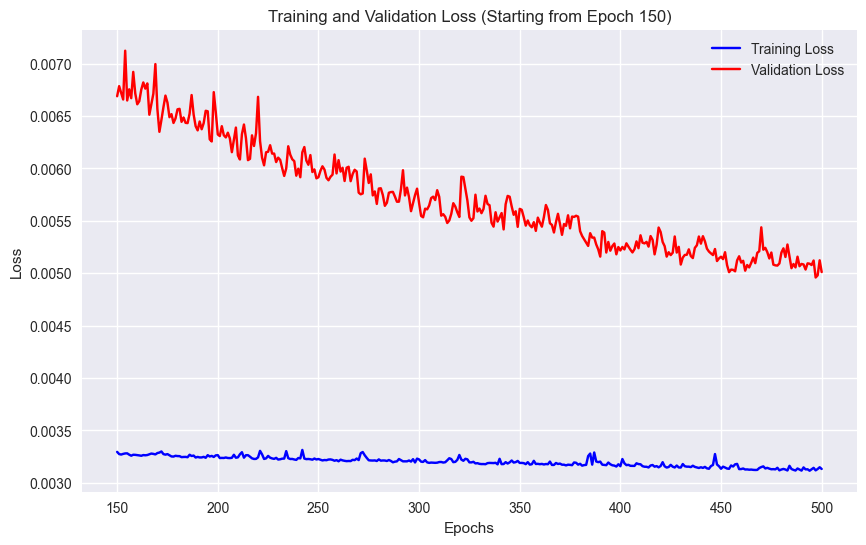

In [20]:
plot_loss_from_epoch(history, 150)

Evaluation on Val and Test sets


      Validation Results:
      mae = 35.59230041503906,
      mse = 3418.381591796875
      
      Test Results:
      mae = 51.75351333618164,
      mse = 3446.326416015625
      


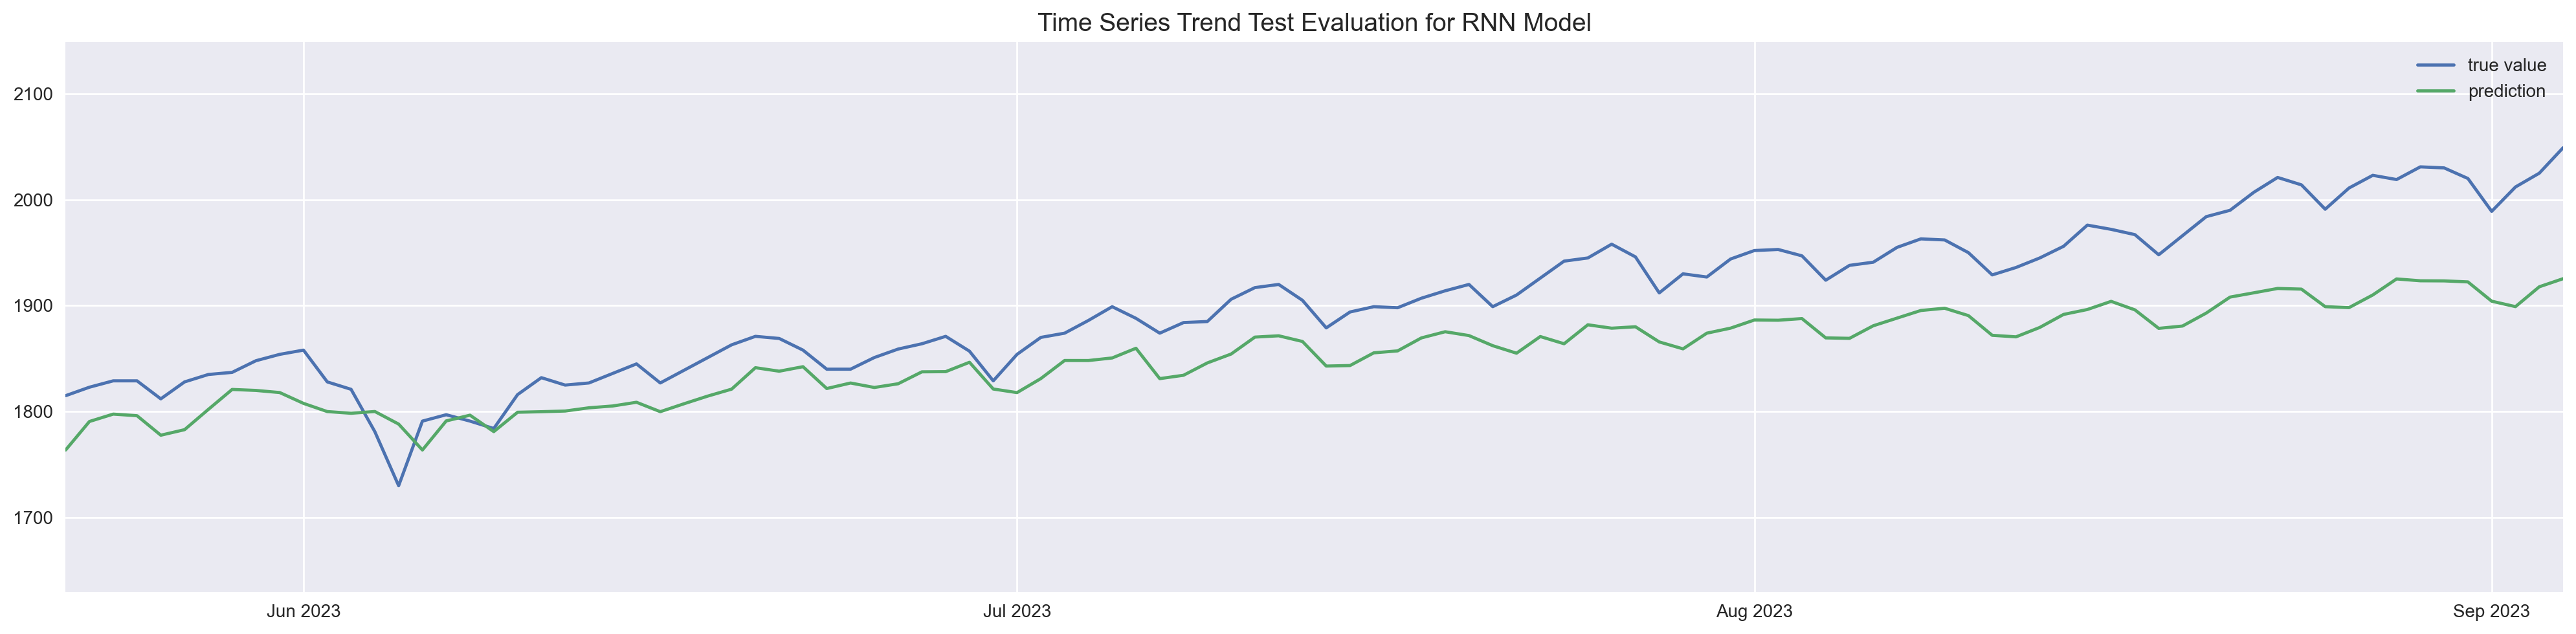

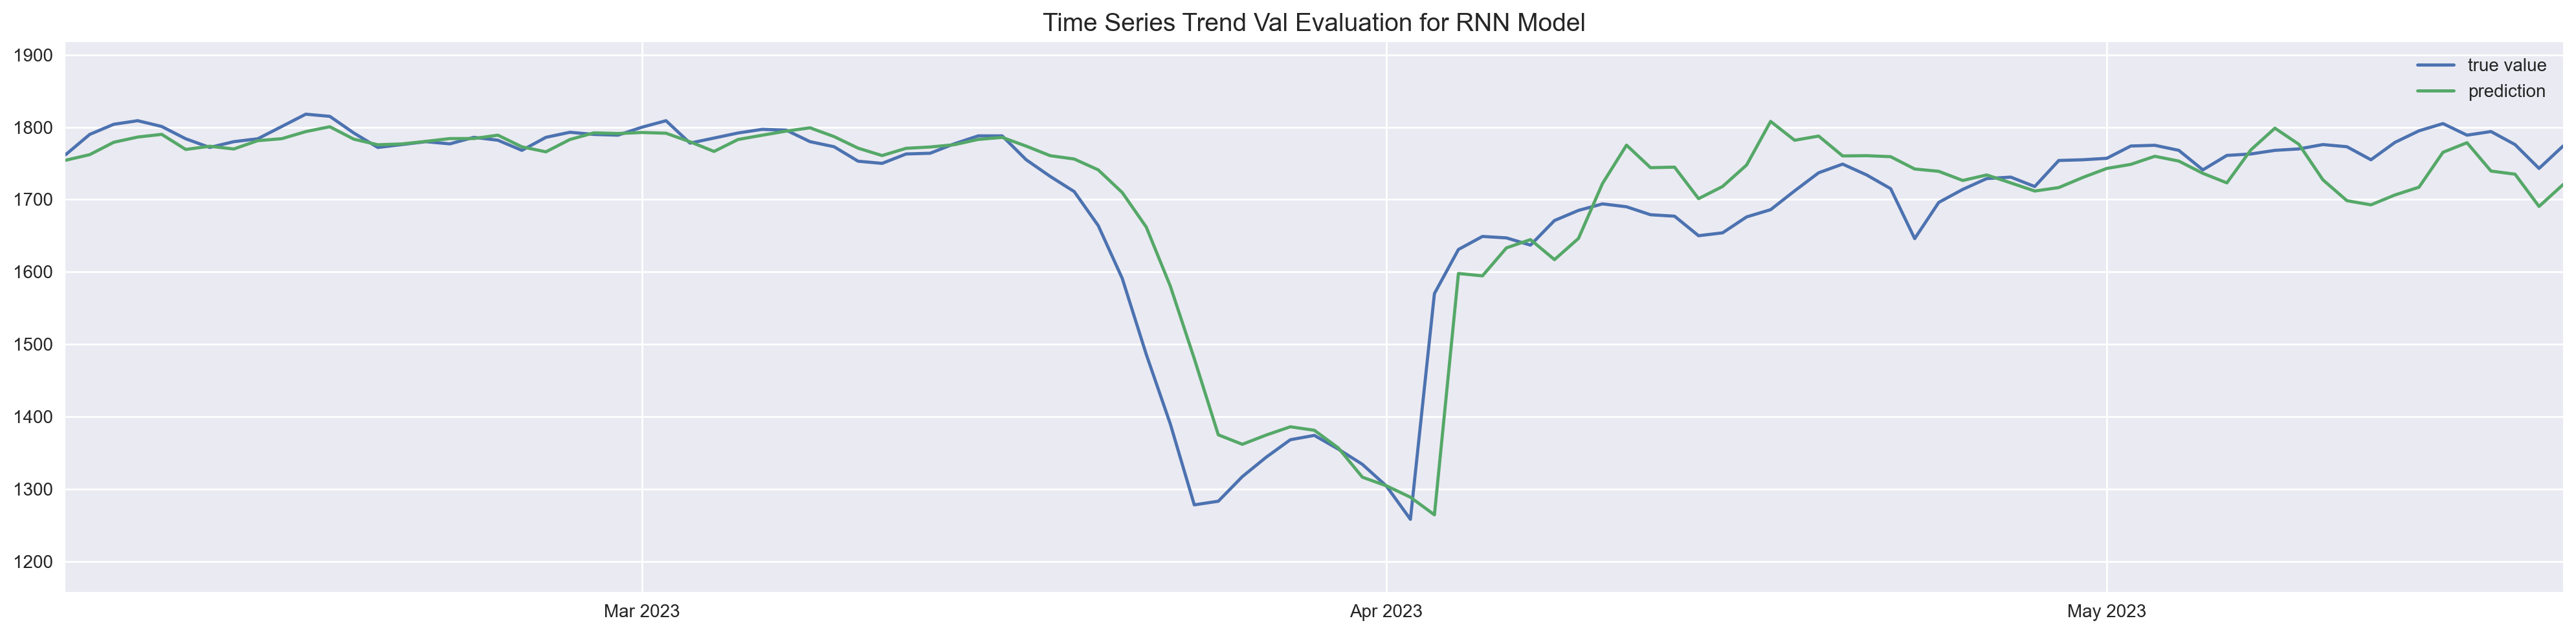

In [45]:
mae_val , mse_val , prediction_val = metric_calculator_val_test(model_RNN , x_val_univariate_forecast , scaler).values()
mae_test , mse_test , prediction_test = metric_calculator_val_test(model_RNN , x_test_univariate , scaler).values()

print(f"""
      Validation Results:
      mae = {mae_val},
      mse = {mse_val}
      
      Test Results:
      mae = {mae_test},
      mse = {mse_test}
      """)
plot_time_series(time_test, (x_test_univariate_inversed[G.WINDOW_SIZE:], prediction_test) , series_labels= ('true value' , 'prediction') , title = 'Test Evaluation for RNN Model')
plot_time_series(time_val[:-1], (x_val_univariate_forecast_inversed[G.WINDOW_SIZE:], prediction_val) , series_labels= ('true value' , 'prediction') , title = 'Val Evaluation for RNN Model')

### Evaluation based on Epochs

In [50]:
count = 21
chosen_epochs = np.linspace(300,500 , count , dtype=int)
df_RNN = pd.DataFrame({
    'val_mae': np.zeros(count),
    'val_mse': np.zeros(count),
    'test_mae': np.zeros(count),
    'test_mse' : np.zeros(count)},
    index = chosen_epochs)

for ep in chosen_epochs:
    
    model_RNN = create_uncompiled_model_RNN()
    model_RNN.load_weights(save_path_RNN+f'/model_weights_epoch_{ep}.h5')
    
    mae_val , mse_val , _ = metric_calculator_val_test(model_RNN , x_val_univariate_forecast , scaler).values()
    mae_test , mse_test , _ = metric_calculator_val_test(model_RNN , x_test_univariate , scaler).values()
    
    df_RNN.loc[ep, : ] = [mae_val , mse_val , mae_test , mse_test]

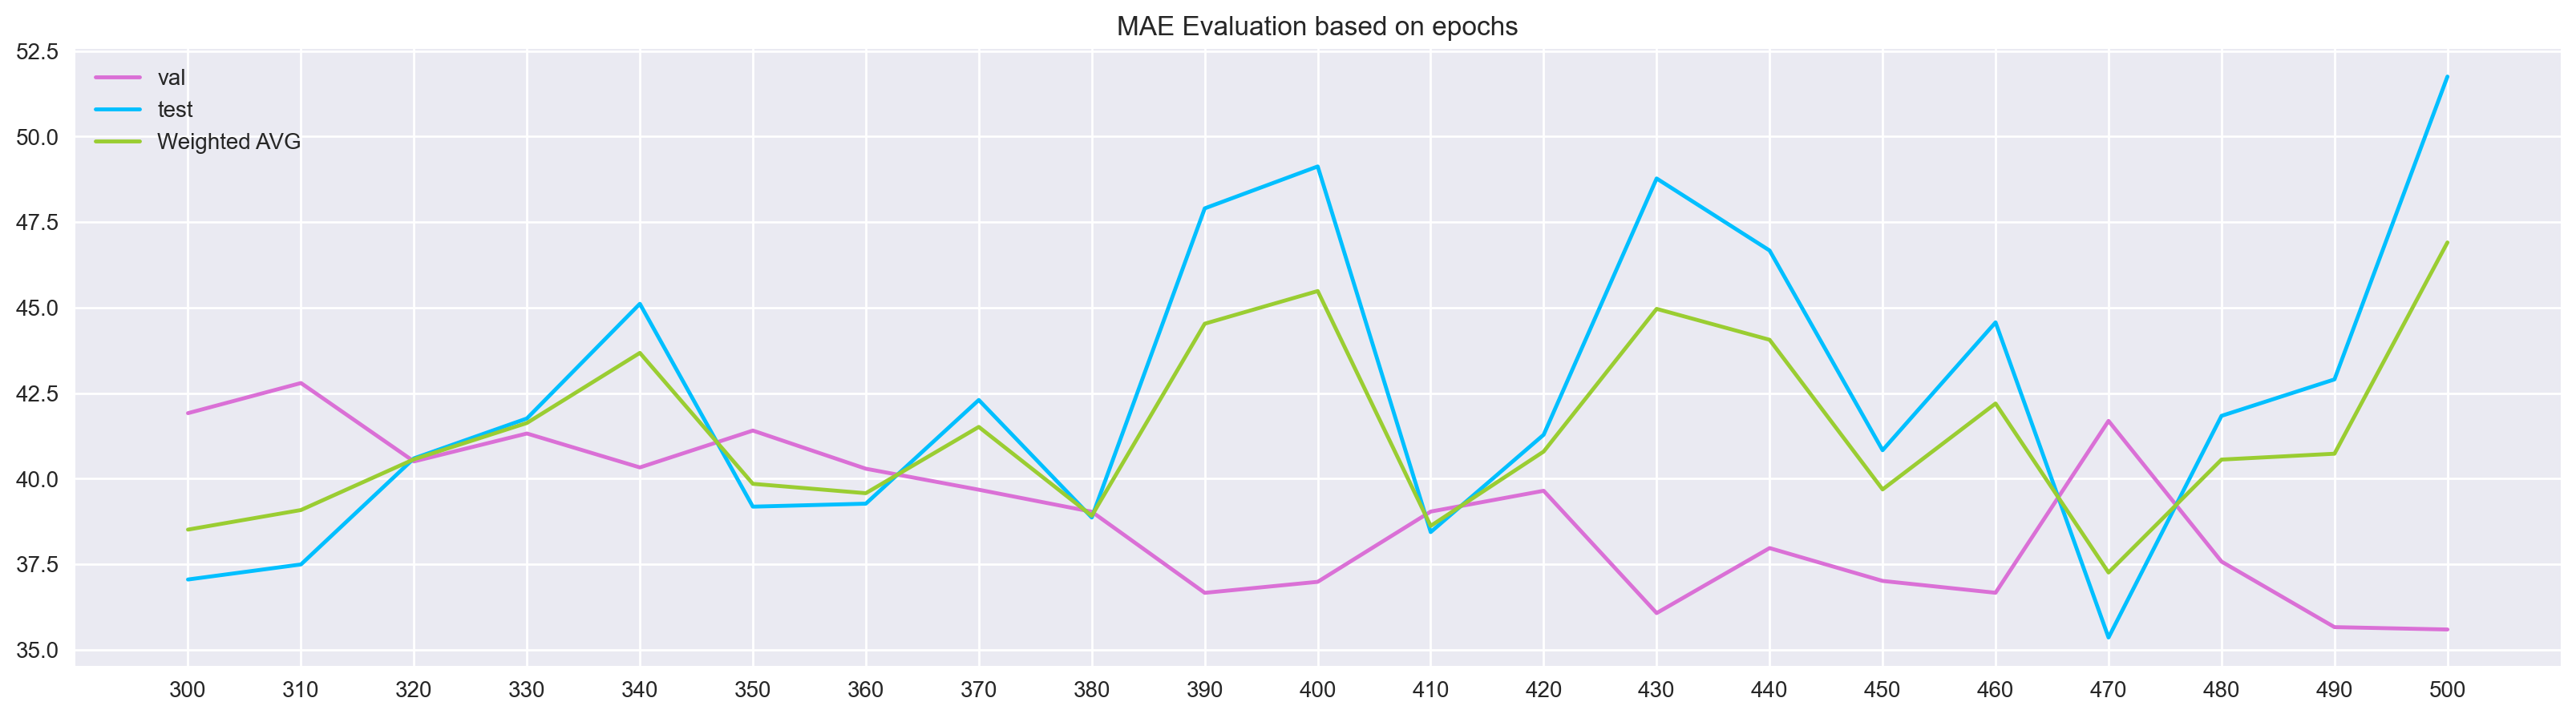

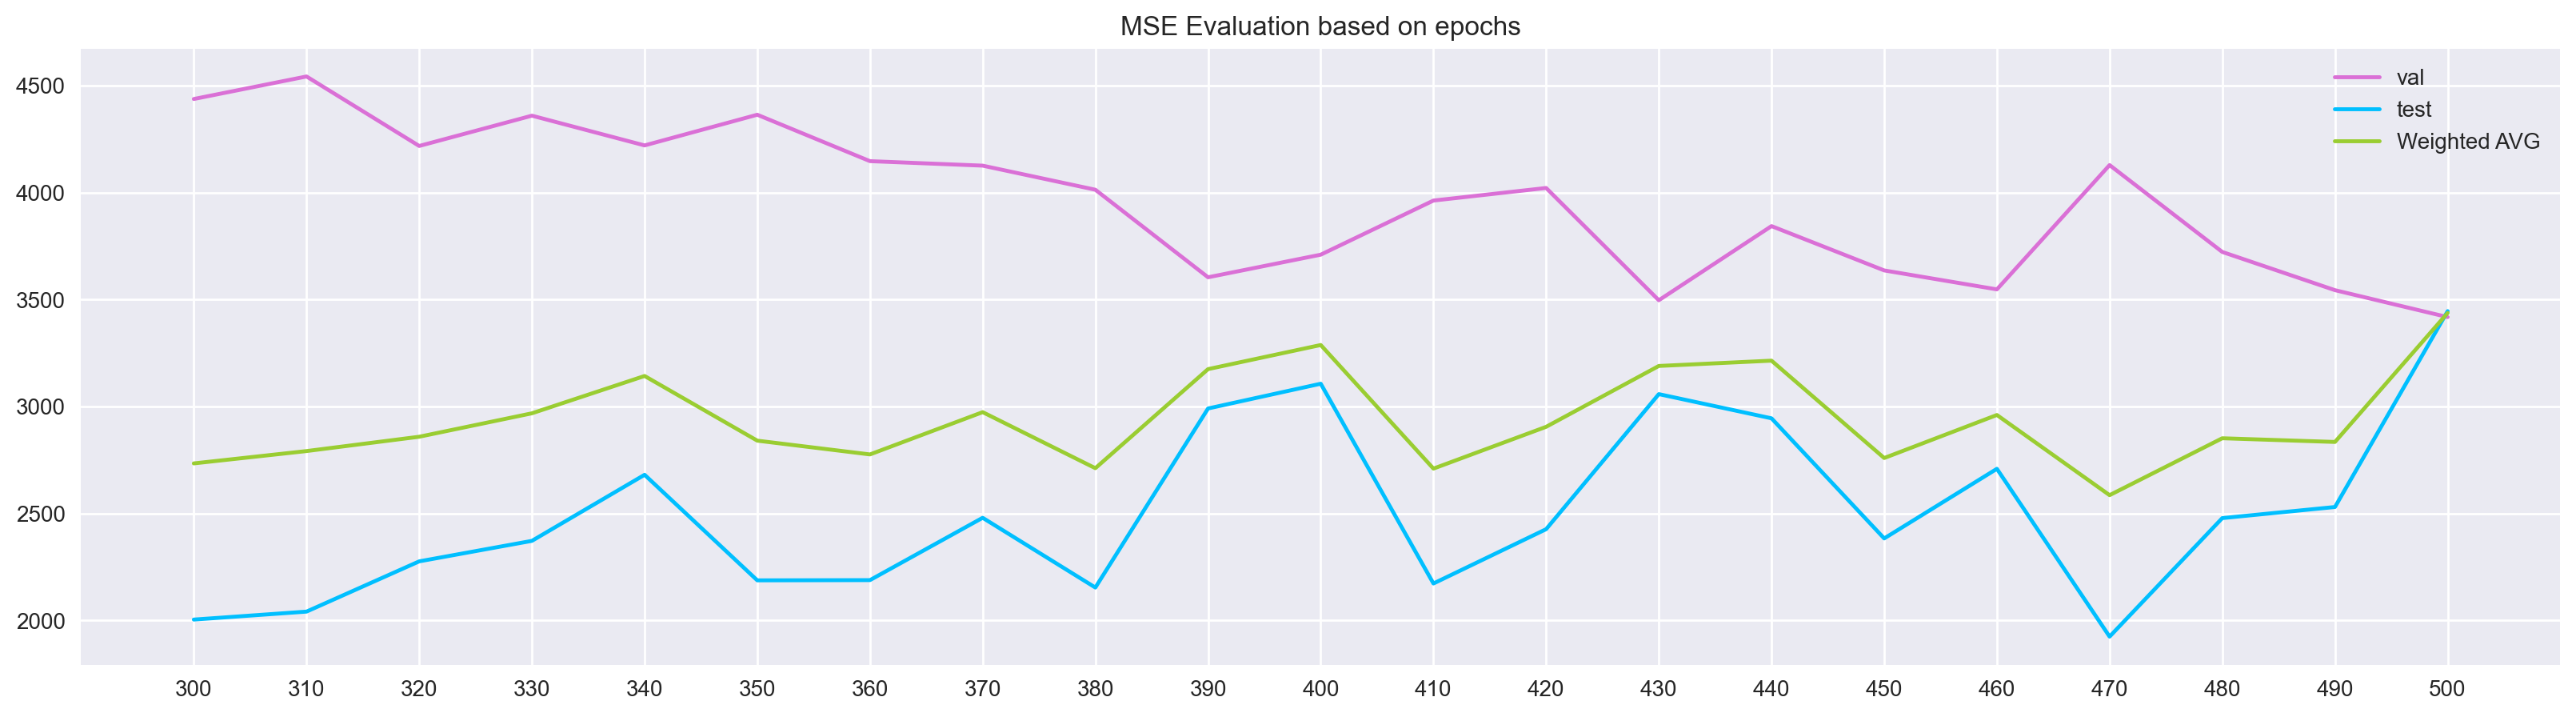

In [57]:
plot_mae_mse_based_on_epochs(df_RNN.index , df_RNN.val_mae , df_RNN.test_mae , Title='MAE')
plot_mae_mse_based_on_epochs(df_RNN.index , df_RNN.val_mse , df_RNN.test_mse , Title='MSE')

## LSTM

In [24]:
tf.keras.backend.clear_session()
def create_uncompiled_model_LSTM():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x , axis=-1),
                               input_shape = [G.WINDOW_SIZE]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True , kernel_regularizer=l2(0.00001))),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True , kernel_regularizer=l2(0.00001))),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False , kernel_regularizer=l2(0.00001))),
        tf.keras.layers.Dropout(0.01),
        # tf.keras.layers.Dense(12 , activation = 'relu'),
        tf.keras.layers.Dense(8 , activation = 'relu'),
        tf.keras.layers.Dense(1 , activation = 'linear'),
    ])
    
    return model

In [25]:
def create_model_LSTM(learning_rate):
    # initial_learning_rate = learning_rate
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate,
    #     decay_steps=20,  # Decay every 50 epochs (you can adjust this)
    #     decay_rate=0.1,  # Decay rate
    #     staircase=True  # Optional: Make the decay step-wise
    # )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model = create_uncompiled_model_LSTM()
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])  
    
    return model

In [26]:
save_path_LSTM = '2. Univariate TS Models/LSTM'
os.makedirs(save_path_LSTM , exist_ok = True)
model_LSTM = create_model_LSTM(learning_rate=5e-4)
checkpoint_callback = ModelCheckpoint(save_path_LSTM+"/model_weights_epoch_{epoch:03d}.h5", save_weights_only=True, save_freq=1)
history = model_LSTM.fit(x_train_univariate , validation_data = x_val_univariate,
                        epochs = 500, 
                        callbacks=[checkpoint_callback]
                                                )

Epoch 1/500
7/7 [==============================] - 11s 559ms/step - loss: 0.2389 - mae: 0.6744 - val_loss: 0.2103 - val_mae: 0.6248
Epoch 2/500
7/7 [==============================] - 1s 92ms/step - loss: 0.0868 - mae: 0.3815 - val_loss: 0.0211 - val_mae: 0.1803
Epoch 3/500
7/7 [==============================] - 1s 89ms/step - loss: 0.0154 - mae: 0.1289 - val_loss: 0.0141 - val_mae: 0.0693
Epoch 4/500
7/7 [==============================] - 1s 90ms/step - loss: 0.0104 - mae: 0.0959 - val_loss: 0.0332 - val_mae: 0.2373
Epoch 5/500
7/7 [==============================] - 1s 102ms/step - loss: 0.0113 - mae: 0.0990 - val_loss: 0.0220 - val_mae: 0.1858
Epoch 6/500
7/7 [==============================] - 1s 97ms/step - loss: 0.0087 - mae: 0.0800 - val_loss: 0.0139 - val_mae: 0.1184
Epoch 7/500
7/7 [==============================] - 1s 102ms/step - loss: 0.0085 - mae: 0.0798 - val_loss: 0.0181 - val_mae: 0.1620
Epoch 8/500
7/7 [==============================] - 1s 89ms/step - loss: 0.0073 - mae: 

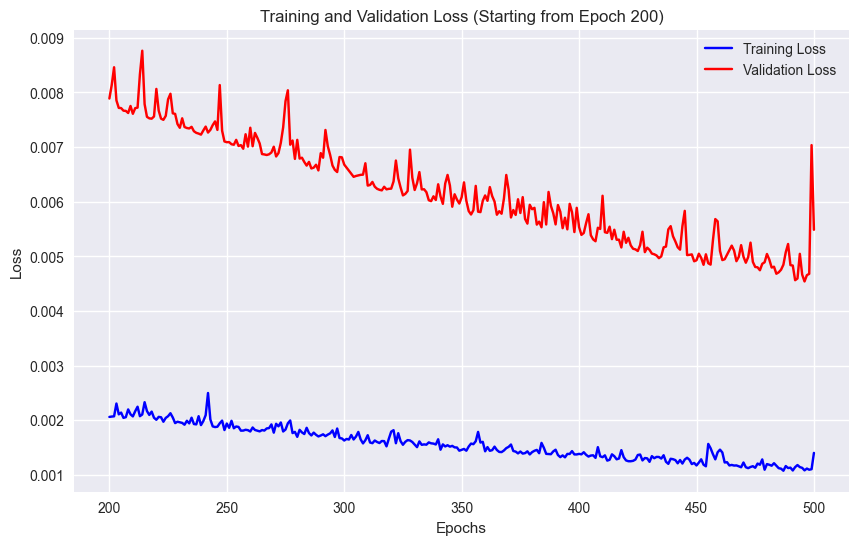

In [31]:
plot_loss_from_epoch(history, 200)

Evaluation on Val and Test sets for the Original number of epochs


      Validation Results:
      mae = 58.09285354614258,
      mse = 8123.22900390625
      
      Test Results:
      mae = 31.225570678710938,
      mse = 1396.313720703125
      


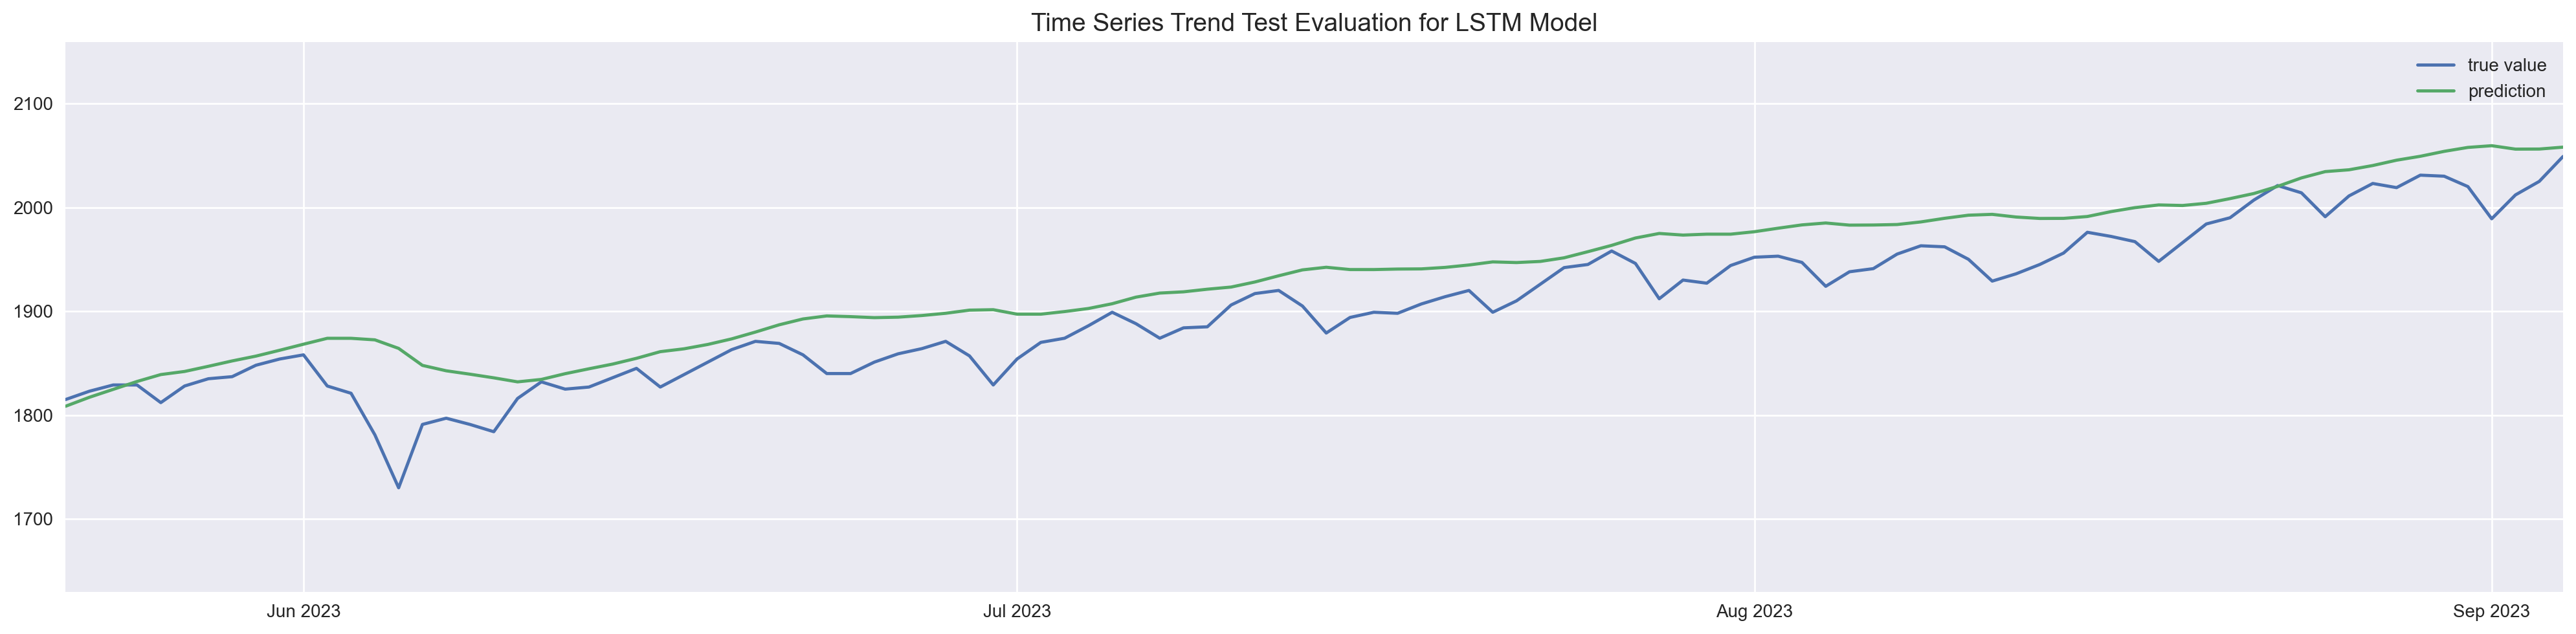

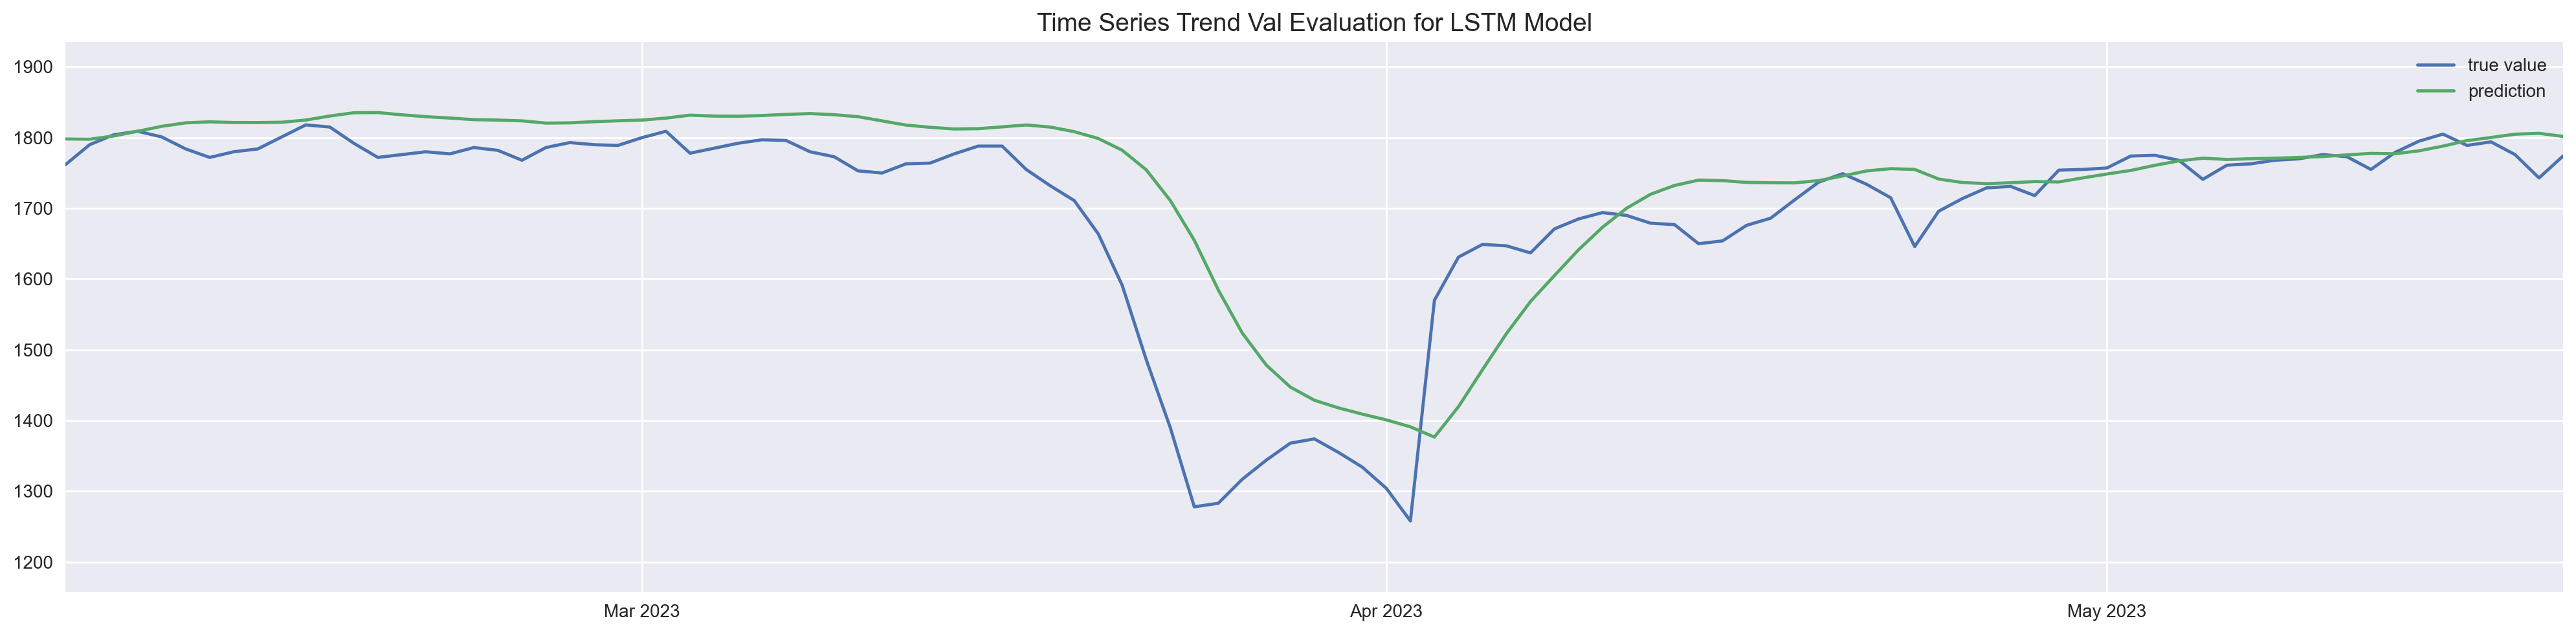

In [28]:
mae_val , mse_val , prediction_val = metric_calculator_val_test(model_LSTM , x_val_univariate_forecast , scaler).values()
mae_test , mse_test , prediction_test = metric_calculator_val_test(model_LSTM , x_test_univariate , scaler).values()

print(f"""
      Validation Results:
      mae = {mae_val},
      mse = {mse_val}
      
      Test Results:
      mae = {mae_test},
      mse = {mse_test}
      """)
plot_time_series(time_test, (x_test_univariate_inversed[G.WINDOW_SIZE:], prediction_test) , series_labels= ('true value' , 'prediction') , title = 'Test Evaluation for LSTM Model')
plot_time_series(time_val[:-1], (x_val_univariate_forecast_inversed[G.WINDOW_SIZE:], prediction_val) , series_labels= ('true value' , 'prediction') , title = 'Val Evaluation for LSTM Model')

### Evaluation based on Epochs

In [29]:
count = 21
chosen_epochs = np.linspace(300,500 , count , dtype=int)
df_LSTM = pd.DataFrame({
    'val_mae': np.zeros(count),
    'val_mse': np.zeros(count),
    'test_mae': np.zeros(count),
    'test_mse' : np.zeros(count)},
    index = chosen_epochs)

for ep in chosen_epochs:
    
    model_LSTM = create_uncompiled_model_LSTM()
    model_LSTM.load_weights(save_path_LSTM+f'/model_weights_epoch_{ep}.h5')
    
    mae_val , mse_val , _ = metric_calculator_val_test(model_LSTM , x_val_univariate_forecast , scaler).values()
    mae_test , mse_test , _ = metric_calculator_val_test(model_LSTM , x_test_univariate , scaler).values()
    
    df_LSTM.loc[ep, : ] = [mae_val , mse_val , mae_test , mse_test]

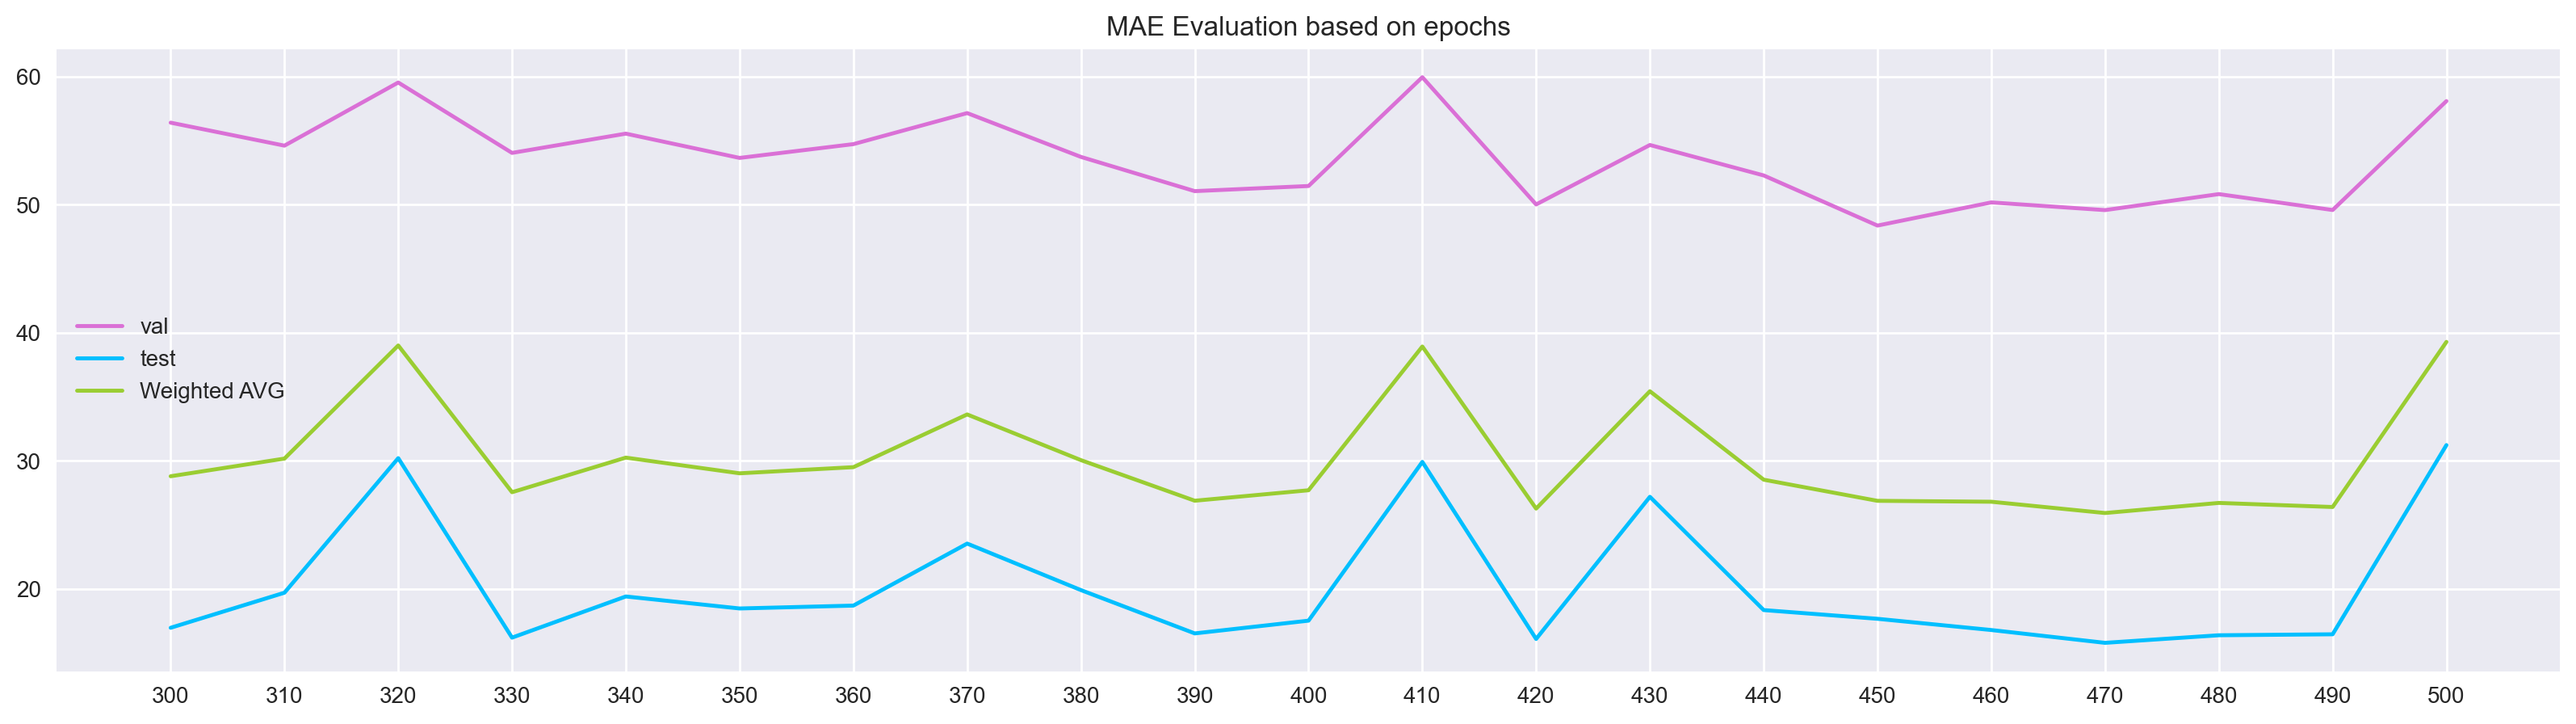

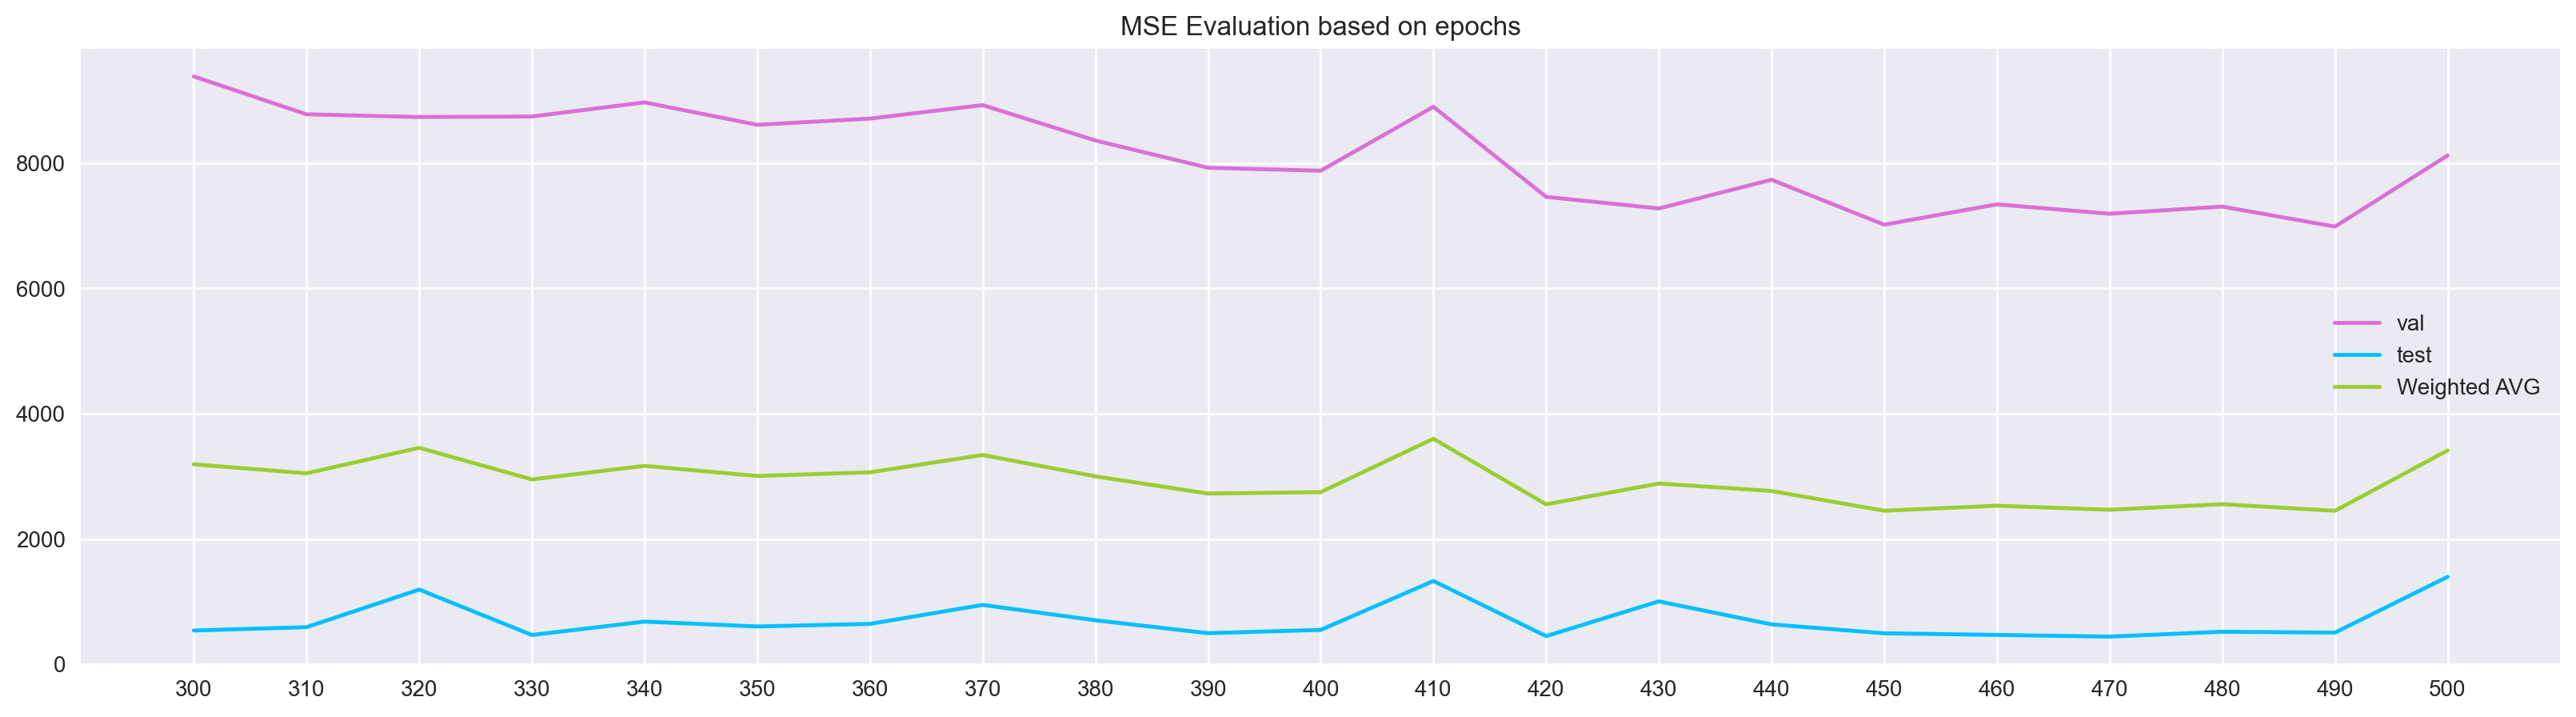

In [30]:
plot_mae_mse_based_on_epochs(df_LSTM.index , df_LSTM.val_mae , df_LSTM.test_mae , Title='MAE')
plot_mae_mse_based_on_epochs(df_LSTM.index , df_LSTM.val_mse , df_LSTM.test_mse , Title='MSE')

In [32]:
df_LSTM

val_mae      val_mse   test_mae     test_mse
300  56.408401  9383.941406  16.957016   538.876526
310  54.613766  8780.037109  19.695774   592.281311
320  59.545300  8736.873047  30.206102  1192.839966
330  54.046917  8744.748047  16.186714   467.609131
340  55.551636  8970.268555  19.401730   681.185486
350  53.655273  8612.291992  18.464687   603.449463
360  54.732674  8711.264648  18.689165   644.689392
370  57.157593  8926.819336  23.532785   947.510620
380  53.733475  8362.620117  19.899759   702.704956
390  51.060780  7926.288574  16.517118   496.230988
400  51.462322  7879.672852  17.513248   548.986267
410  59.959011  8899.750977  29.912052  1329.628052
420  50.020809  7461.572754  16.082882   449.489502
430  54.665627  7276.808105  27.186708  1003.958130
440  52.286572  7735.321289  18.339249   636.749634
450  48.371284  7017.492676  17.658140   494.492828
460  50.180416  7342.738281  16.781469   468.678162
470  49.578823  7192.203125  15.780346   441.383331
480  50.829025  7306.976562  16.372221   519.301575
490  49.586292  6987.124512  16.448372   505.473022
500  58.092854  8123.229004  31.225571  1396.313721


      Validation Results:
      mae = 49.57882308959961,
      mse = 7192.203125
      
      Test Results:
      mae = 15.780345916748047,
      mse = 441.3833312988281
      


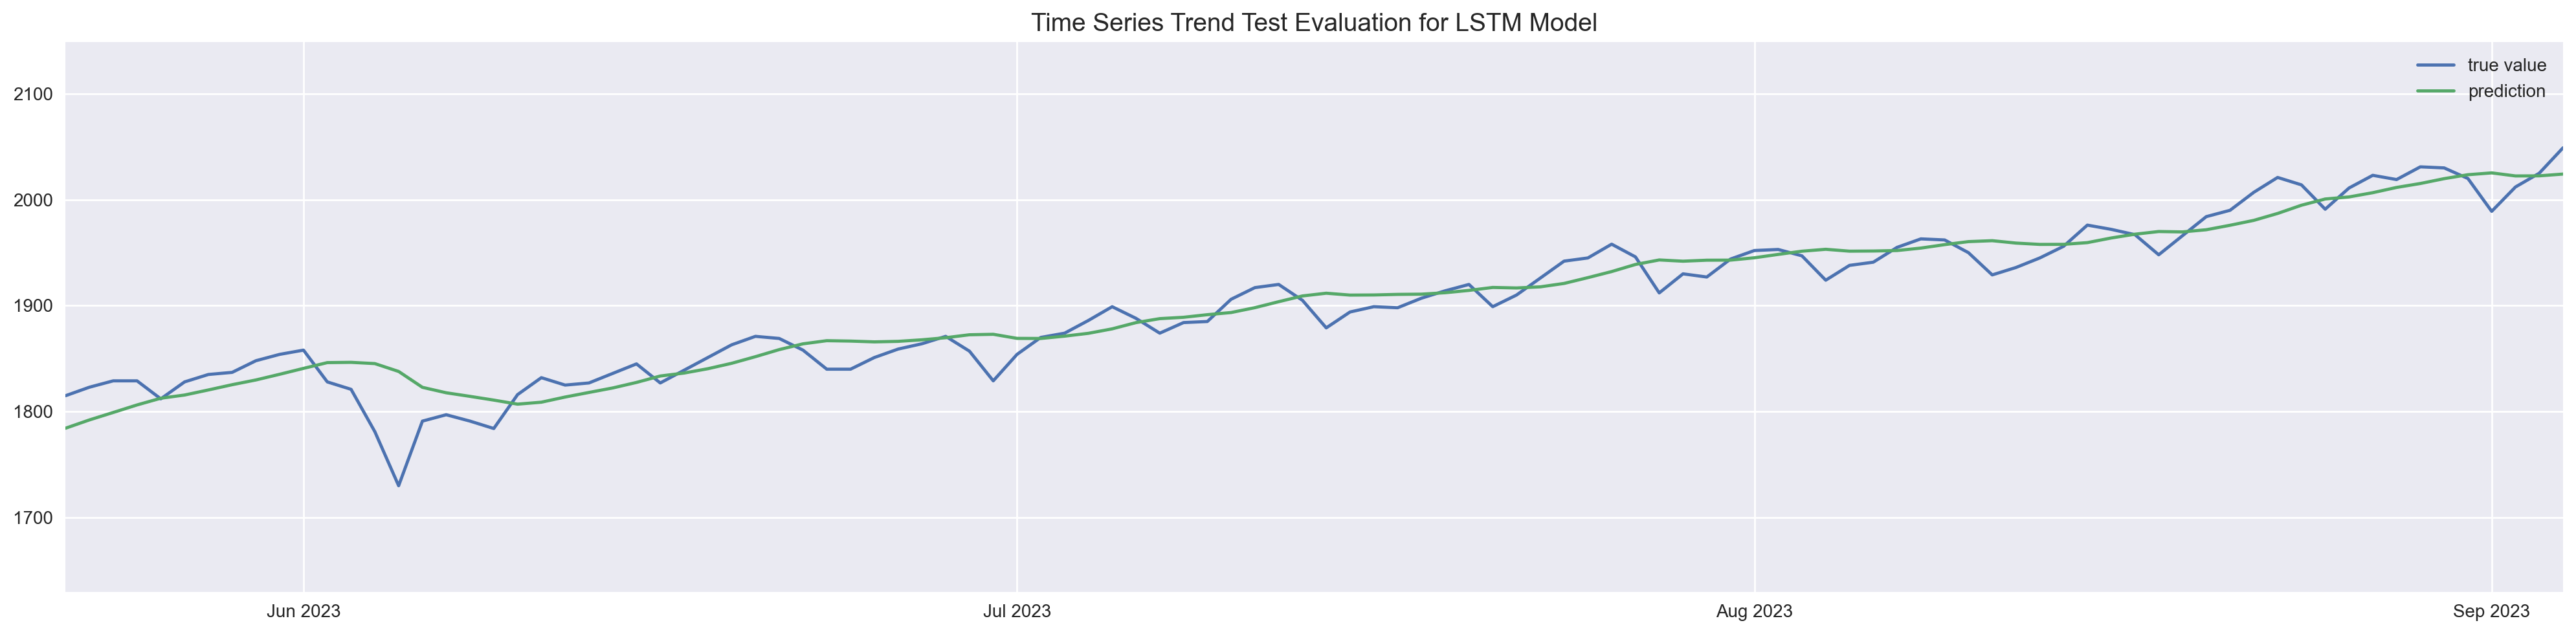

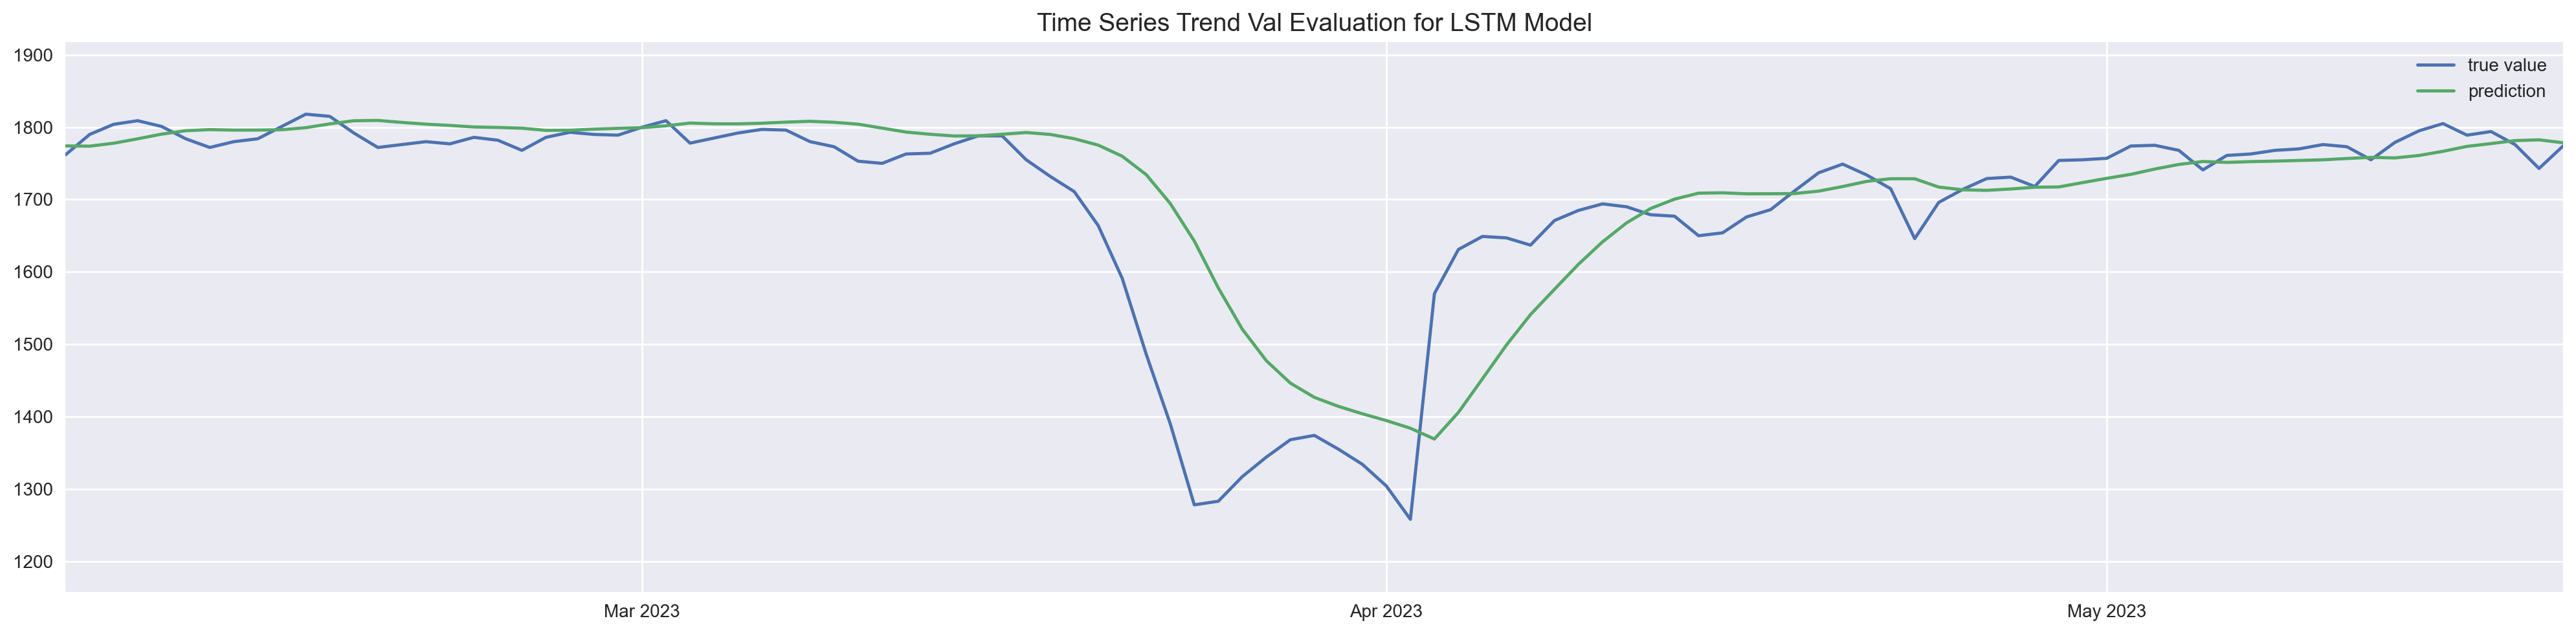

In [33]:
model_LSTM_optimal = create_uncompiled_model_LSTM()
model_LSTM_optimal.load_weights(save_path_LSTM+f'/model_weights_epoch_{470}.h5')

mae_val , mse_val , prediction_val = metric_calculator_val_test(model_LSTM_optimal , x_val_univariate_forecast , scaler).values()
mae_test , mse_test , prediction_test = metric_calculator_val_test(model_LSTM_optimal , x_test_univariate , scaler).values()

print(f"""
      Validation Results:
      mae = {mae_val},
      mse = {mse_val}
      
      Test Results:
      mae = {mae_test},
      mse = {mse_test}
      """)
plot_time_series(time_test, (x_test_univariate_inversed[G.WINDOW_SIZE:], prediction_test) , series_labels= ('true value' , 'prediction') , title = 'Test Evaluation for LSTM Model')
plot_time_series(time_val[:-1], (x_val_univariate_forecast_inversed[G.WINDOW_SIZE:], prediction_val) , series_labels= ('true value' , 'prediction') , title = 'Val Evaluation for LSTM Model')

## Conv1D-LSTM

In [22]:
tf.keras.backend.clear_session()
def create_uncompiled_model_ConvLSTM():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=70, kernel_size=7,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(210, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(16 , activation = 'relu'),
        # tf.keras.layers.Dense(10 , activation = 'relu'),
        tf.keras.layers.Dense(1 , activation = 'linear'),

    ])
    
    return model

In [23]:
tf.keras.backend.clear_session()
def create_model_ConvLSTM(learning_rate):

    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    model = create_uncompiled_model_ConvLSTM()
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])  
    
    return model

In [24]:
save_path_ConvLSTM = '2. Univariate TS Models/ConvLSTM'
os.makedirs(save_path_ConvLSTM , exist_ok = True)
model_ConvLSTM = create_model_ConvLSTM(learning_rate=0.00075)
checkpoint_callback = ModelCheckpoint(save_path_ConvLSTM+"/model_weights_epoch_{epoch:03d}.h5", save_weights_only=True, save_freq=1)
history = model_ConvLSTM.fit(x_train_univariate , validation_data = x_val_univariate,
                        epochs = 500, 
                        callbacks=[checkpoint_callback]
                                                )

Epoch 1/500
7/7 [==============================] - 11s 690ms/step - loss: 0.0972 - mae: 0.3497 - val_loss: 0.0601 - val_mae: 0.3325
Epoch 2/500
7/7 [==============================] - 2s 274ms/step - loss: 0.0166 - mae: 0.1523 - val_loss: 0.0210 - val_mae: 0.1369
Epoch 3/500
7/7 [==============================] - 2s 272ms/step - loss: 0.0056 - mae: 0.0887 - val_loss: 0.0219 - val_mae: 0.2033
Epoch 4/500
7/7 [==============================] - 2s 275ms/step - loss: 0.0044 - mae: 0.0773 - val_loss: 0.0119 - val_mae: 0.0831
Epoch 5/500
7/7 [==============================] - 2s 268ms/step - loss: 0.0026 - mae: 0.0599 - val_loss: 0.0131 - val_mae: 0.1405
Epoch 6/500
7/7 [==============================] - 2s 275ms/step - loss: 0.0018 - mae: 0.0485 - val_loss: 0.0113 - val_mae: 0.1070
Epoch 7/500
7/7 [==============================] - 2s 273ms/step - loss: 0.0015 - mae: 0.0442 - val_loss: 0.0118 - val_mae: 0.1207
Epoch 8/500
7/7 [==============================] - 2s 274ms/step - loss: 0.0014 - 

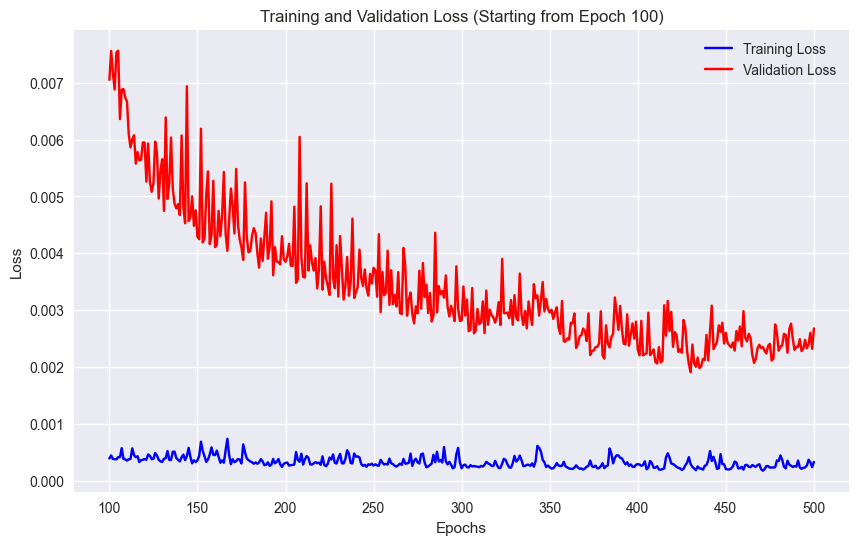

In [25]:
plot_loss_from_epoch(history, 100)

Evaluation on Val and Test sets for the Original number of epochs


      Validation Results:
      mae = 42.04994583129883,
      mse = 4581.4423828125
      
      Test Results:
      mae = 22.570796966552734,
      mse = 672.0077514648438
      


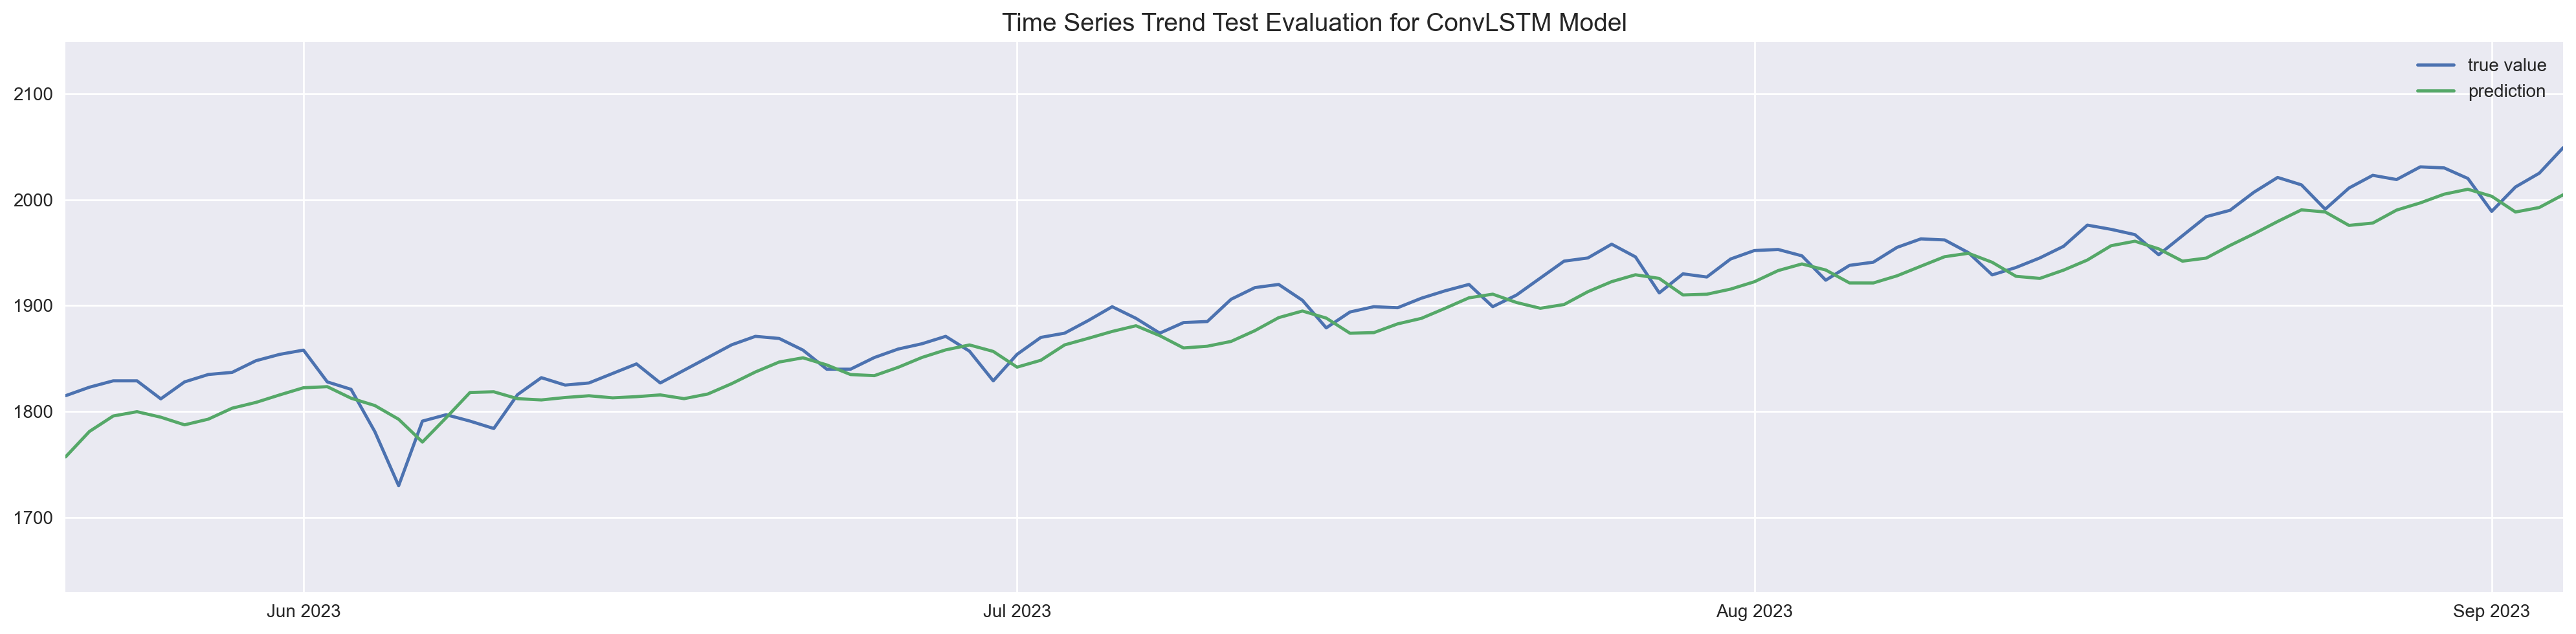

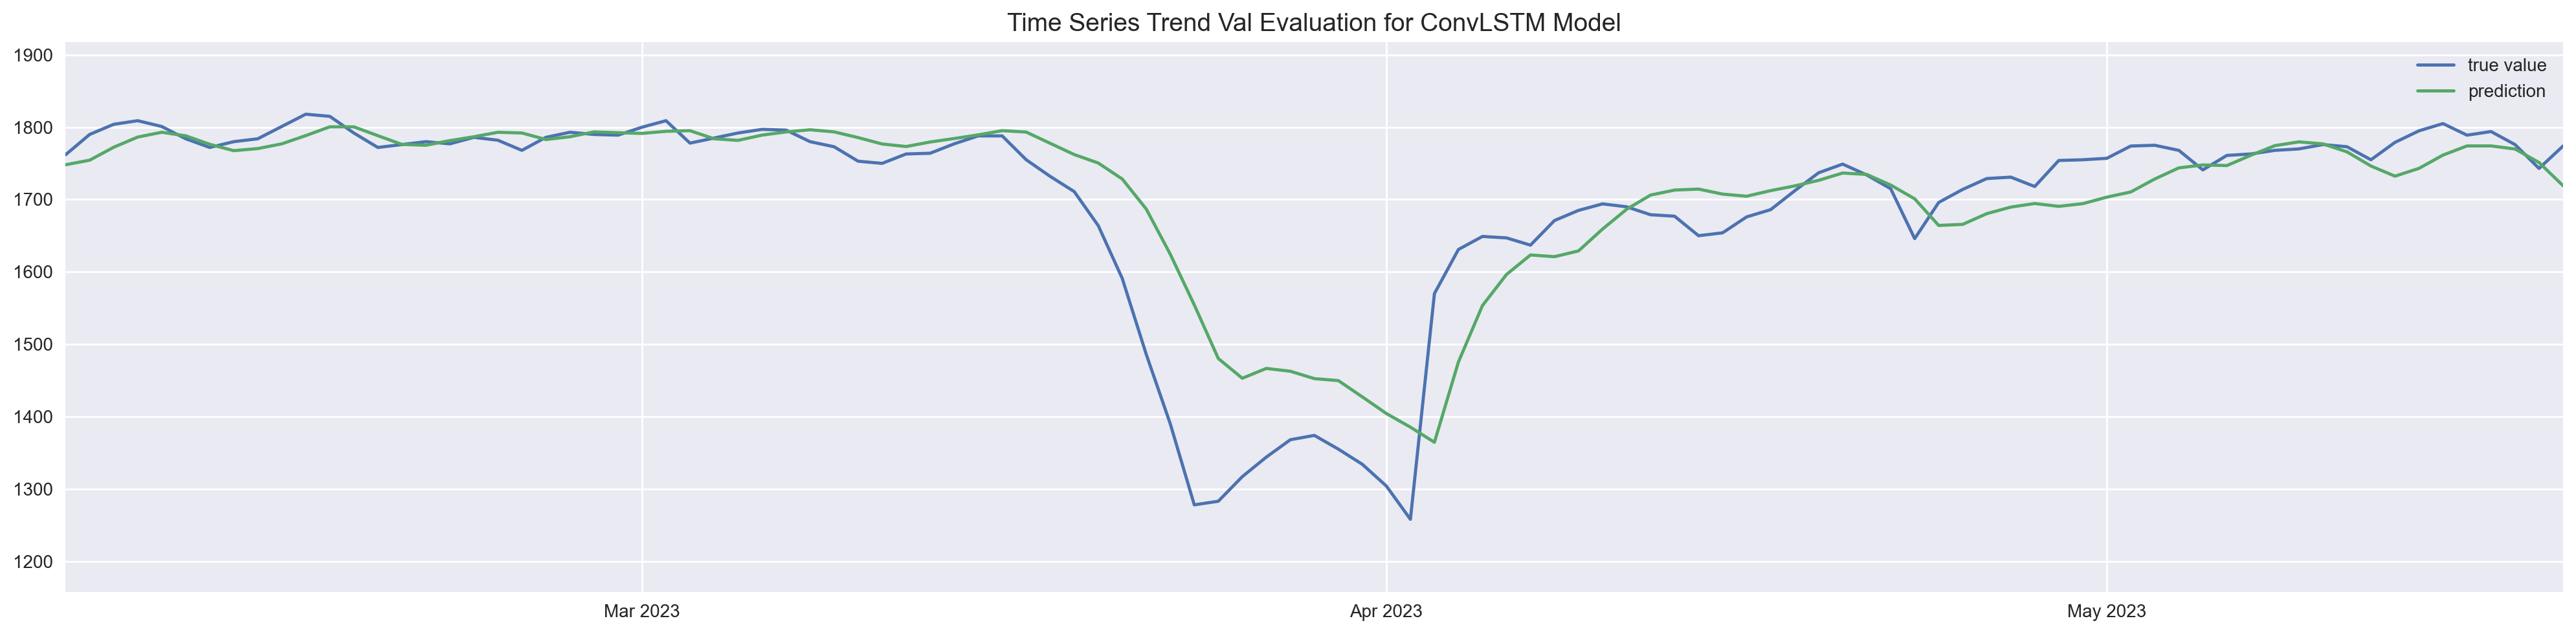

In [26]:
mae_val , mse_val , prediction_val = metric_calculator_val_test(model_ConvLSTM , x_val_univariate_forecast , scaler).values()
mae_test , mse_test , prediction_test = metric_calculator_val_test(model_ConvLSTM , x_test_univariate , scaler).values()

print(f"""
      Validation Results:
      mae = {mae_val},
      mse = {mse_val}
      
      Test Results:
      mae = {mae_test},
      mse = {mse_test}
      """)
plot_time_series(time_test, (x_test_univariate_inversed[G.WINDOW_SIZE:], prediction_test) , series_labels= ('true value' , 'prediction') , title = 'Test Evaluation for ConvLSTM Model')
plot_time_series(time_val[:-1], (x_val_univariate_forecast_inversed[G.WINDOW_SIZE:], prediction_val) , series_labels= ('true value' , 'prediction') , title = 'Val Evaluation for ConvLSTM Model')

### Evaluation based on Epochs

In [27]:
count = 21
chosen_epochs = np.linspace(300,500 , count , dtype=int)
df_ConvLSTM = pd.DataFrame({
    'val_mae': np.zeros(count),
    'val_mse': np.zeros(count),
    'test_mae': np.zeros(count),
    'test_mse' : np.zeros(count)},
    index = chosen_epochs)

for ep in chosen_epochs:
    
    model_ConvLSTM = create_uncompiled_model_ConvLSTM()
    model_ConvLSTM.load_weights(save_path_ConvLSTM+f'/model_weights_epoch_{ep}.h5')
    
    mae_val , mse_val , _ = metric_calculator_val_test(model_ConvLSTM , x_val_univariate_forecast , scaler).values()
    mae_test , mse_test , _ = metric_calculator_val_test(model_ConvLSTM , x_test_univariate , scaler).values()
    
    df_ConvLSTM.loc[ep, : ] = [mae_val , mse_val , mae_test , mse_test]

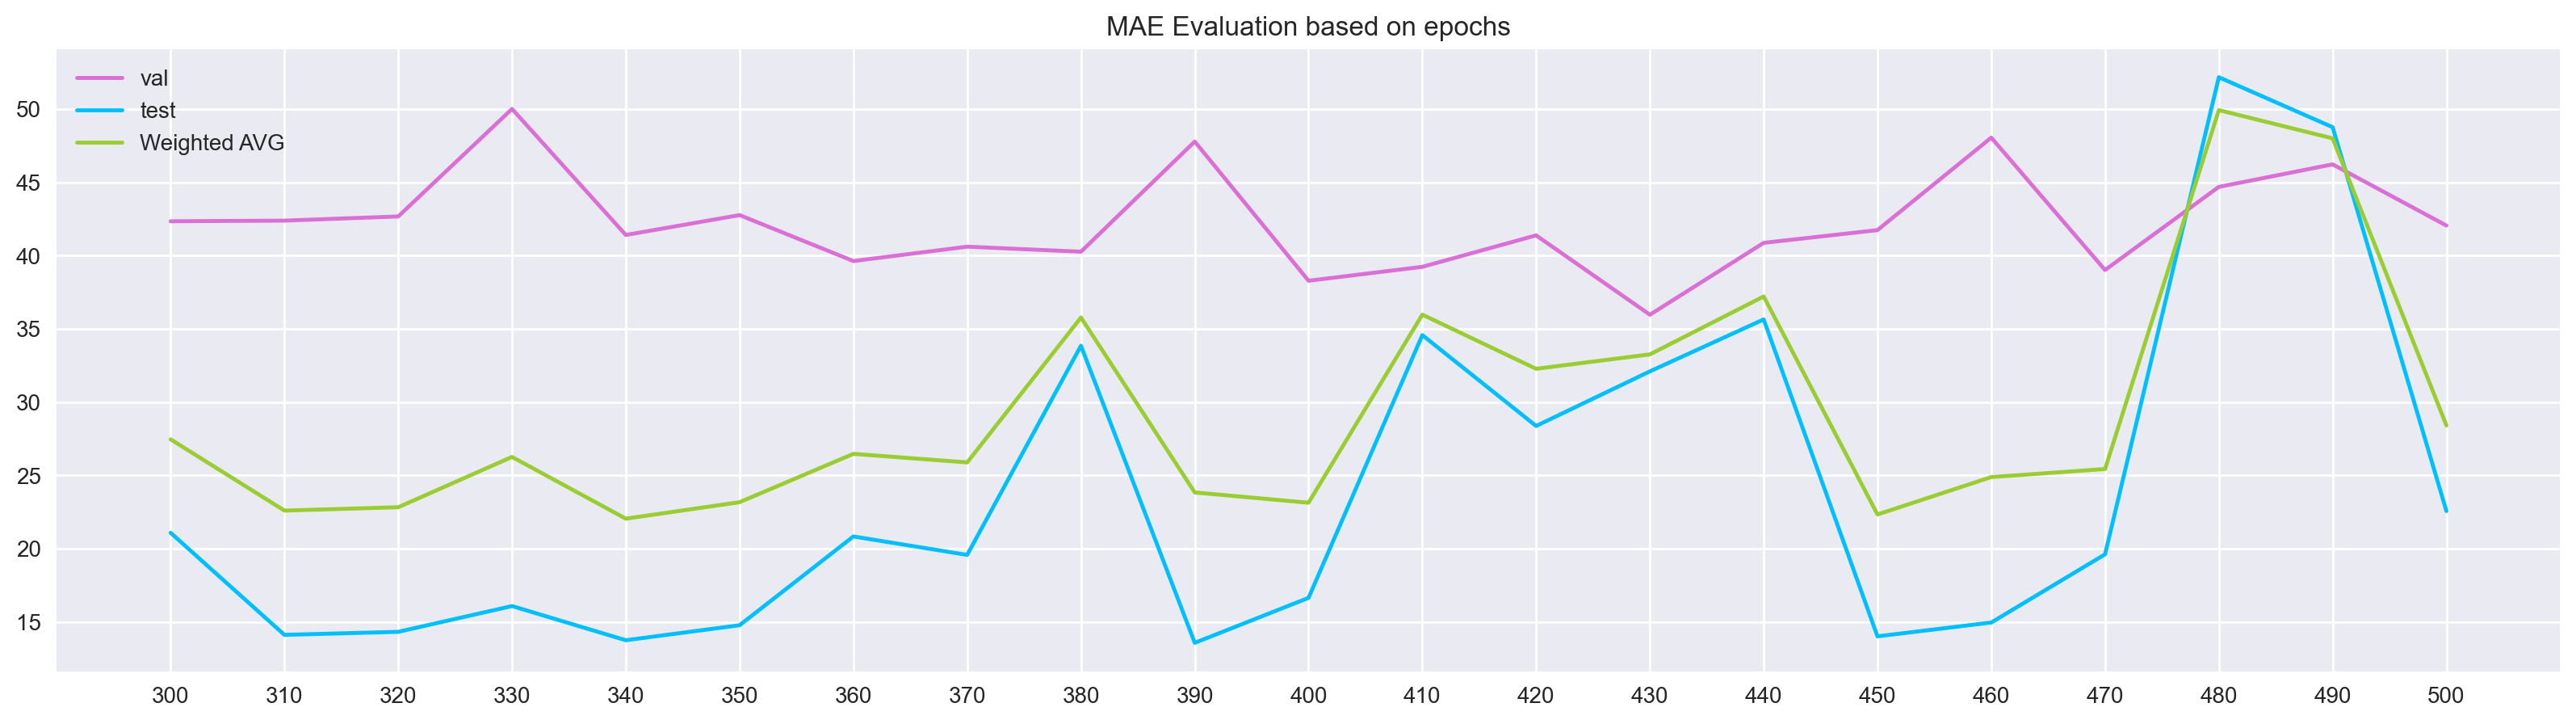

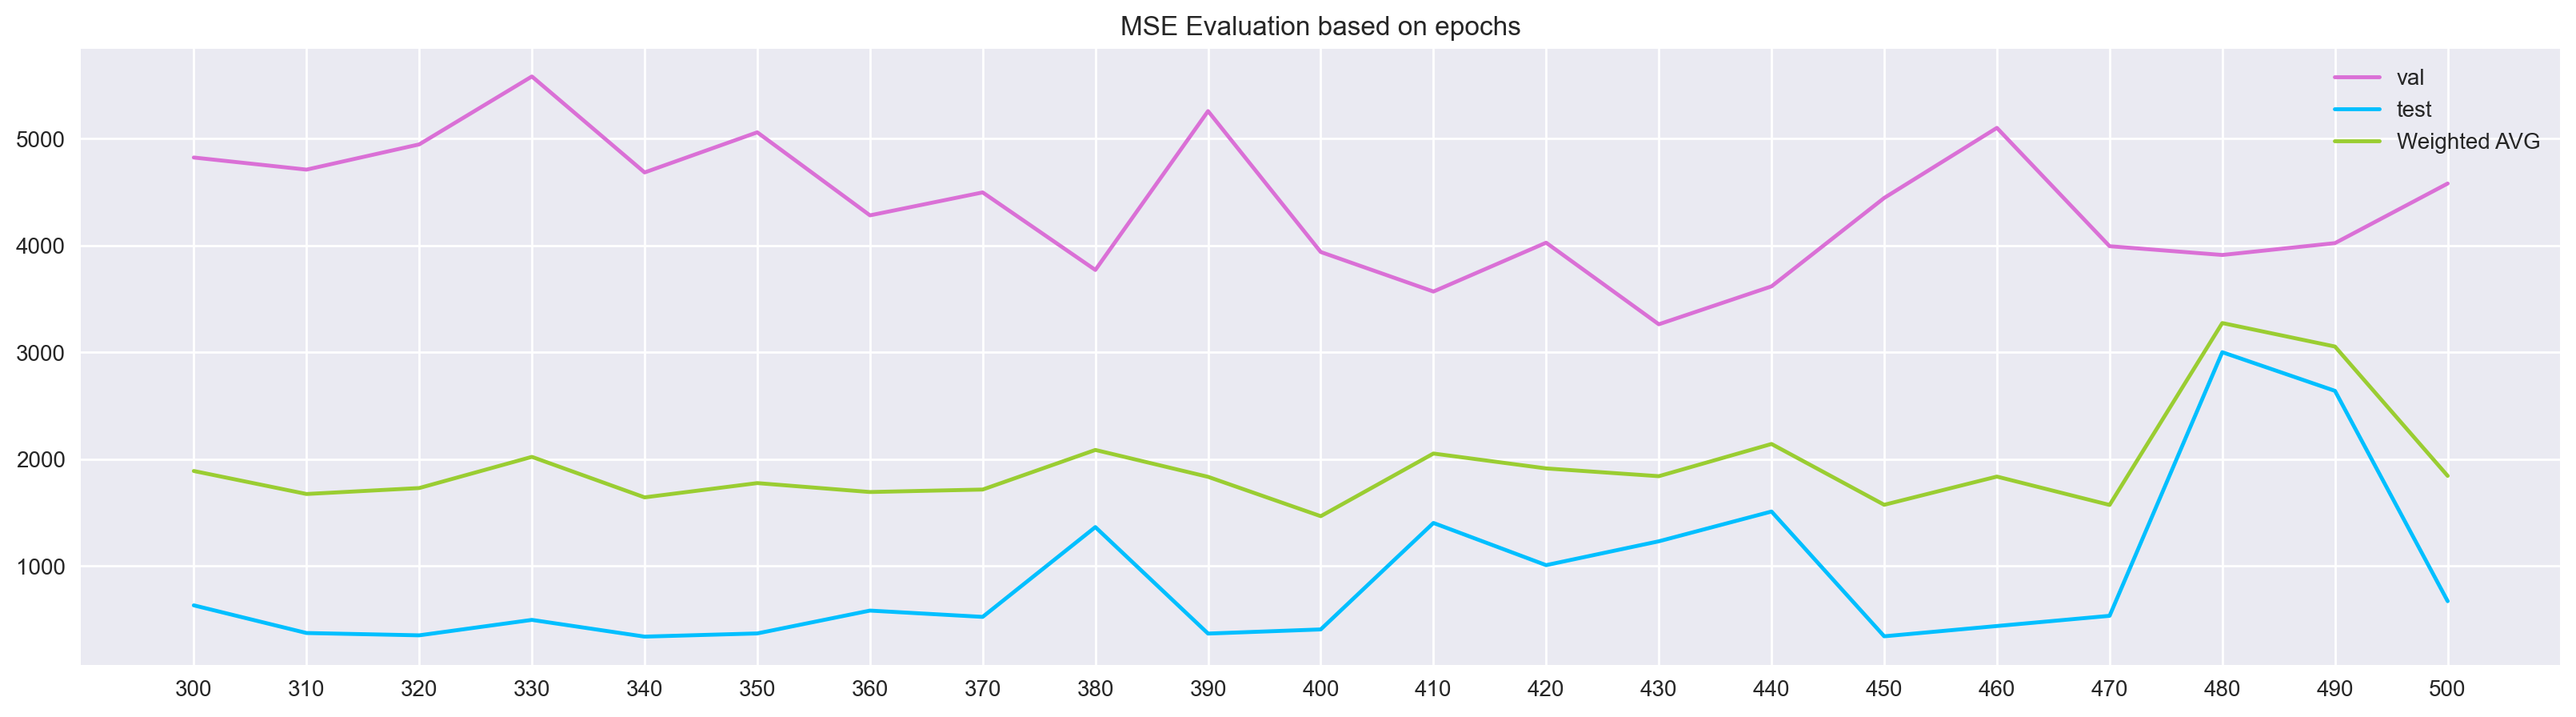

In [28]:
plot_mae_mse_based_on_epochs(df_ConvLSTM.index , df_ConvLSTM.val_mae , df_ConvLSTM.test_mae , Title='MAE')
plot_mae_mse_based_on_epochs(df_ConvLSTM.index , df_ConvLSTM.val_mse , df_ConvLSTM.test_mse , Title='MSE')

In [29]:
df_ConvLSTM

val_mae      val_mse   test_mae     test_mse
300  42.343391  4824.886719  21.085287   632.885437
310  42.387417  4711.615234  14.122911   373.928925
320  42.672009  4947.662109  14.329849   352.195801
330  50.007713  5583.604980  16.088017   496.689697
340  41.408222  4685.229980  13.756114   340.105835
350  42.764908  5060.740234  14.779479   370.042023
360  39.628304  4283.548340  20.836966   583.869934
370  40.609634  4498.269531  19.579826   524.871826
380  40.266262  3772.431641  33.851131  1365.457520
390  47.783455  5259.342285  13.578589   368.721558
400  38.284687  3940.426758  16.647480   407.579071
410  39.234413  3570.302979  34.576202  1404.206543
420  41.382496  4027.588867  28.375515  1009.166870
430  35.965603  3263.916992  32.100941  1232.430908
440  40.870621  3618.765381  35.645496  1511.170532
450  41.739510  4446.454590  14.022660   343.172058
460  48.049522  5102.269531  14.964284   439.316650
470  39.016163  3994.695801  19.618168   534.807434
480  44.690365  3912.628174  52.172600  3002.530029
490  46.225986  4023.573486  48.761955  2640.657959
500  42.049946  4581.442383  22.570797   672.007751


      Validation Results:
      mae = 42.38741683959961,
      mse = 4711.615234375
      
      Test Results:
      mae = 14.12291145324707,
      mse = 373.9289245605469
      


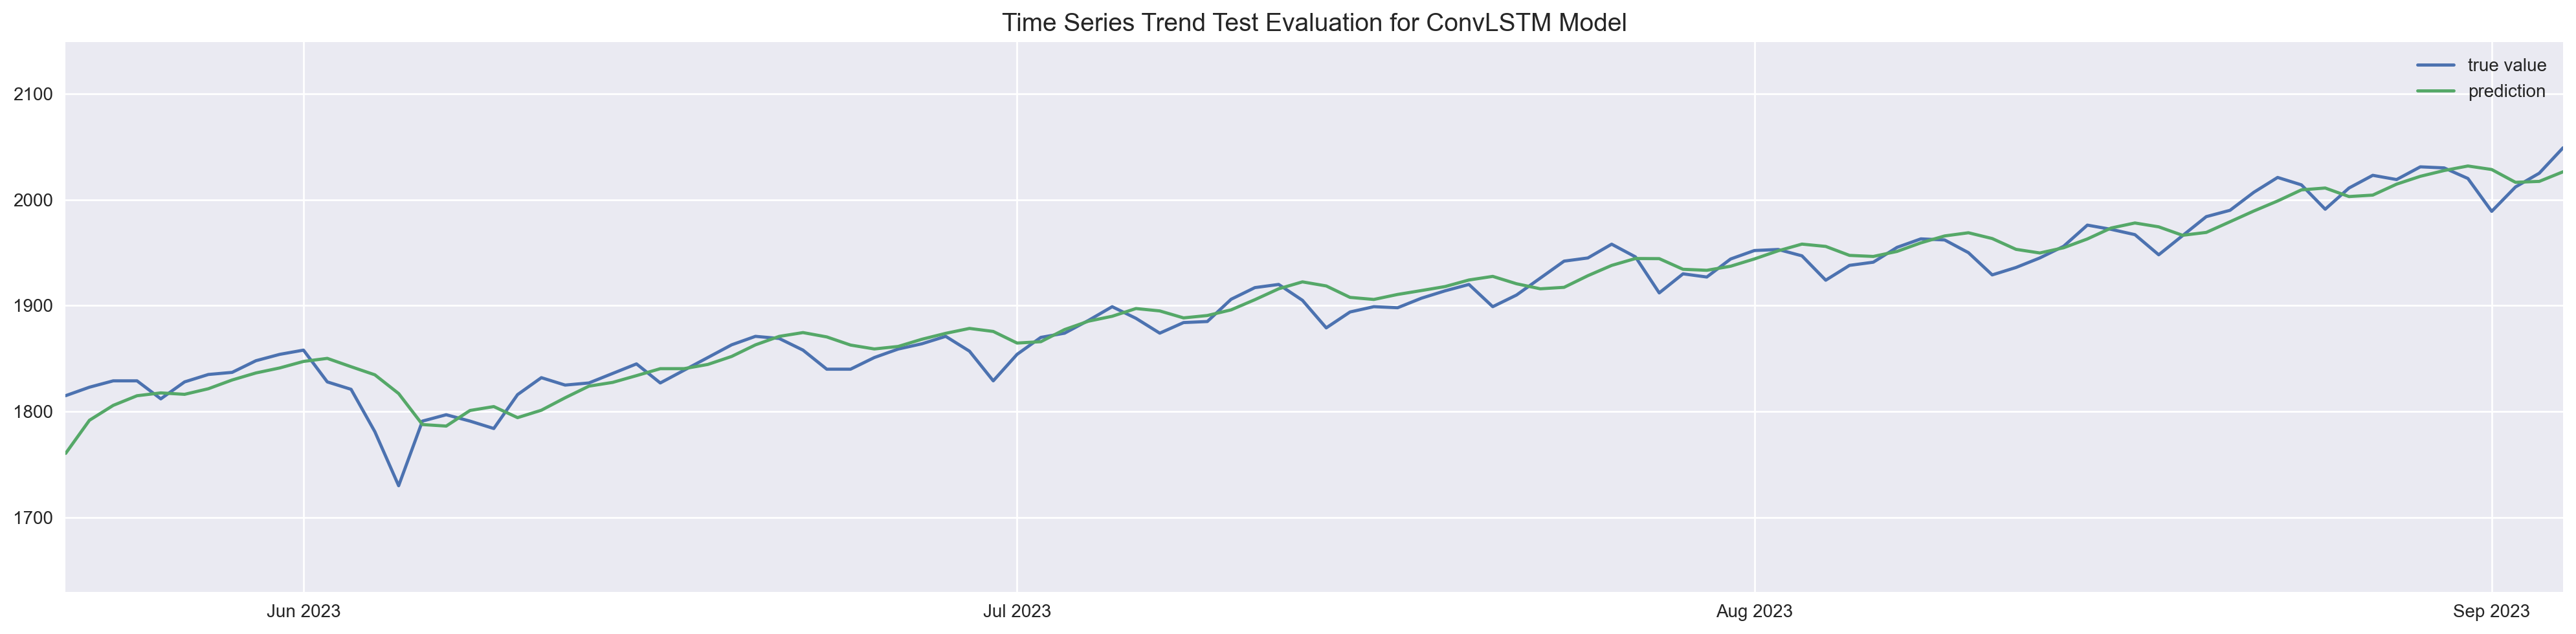

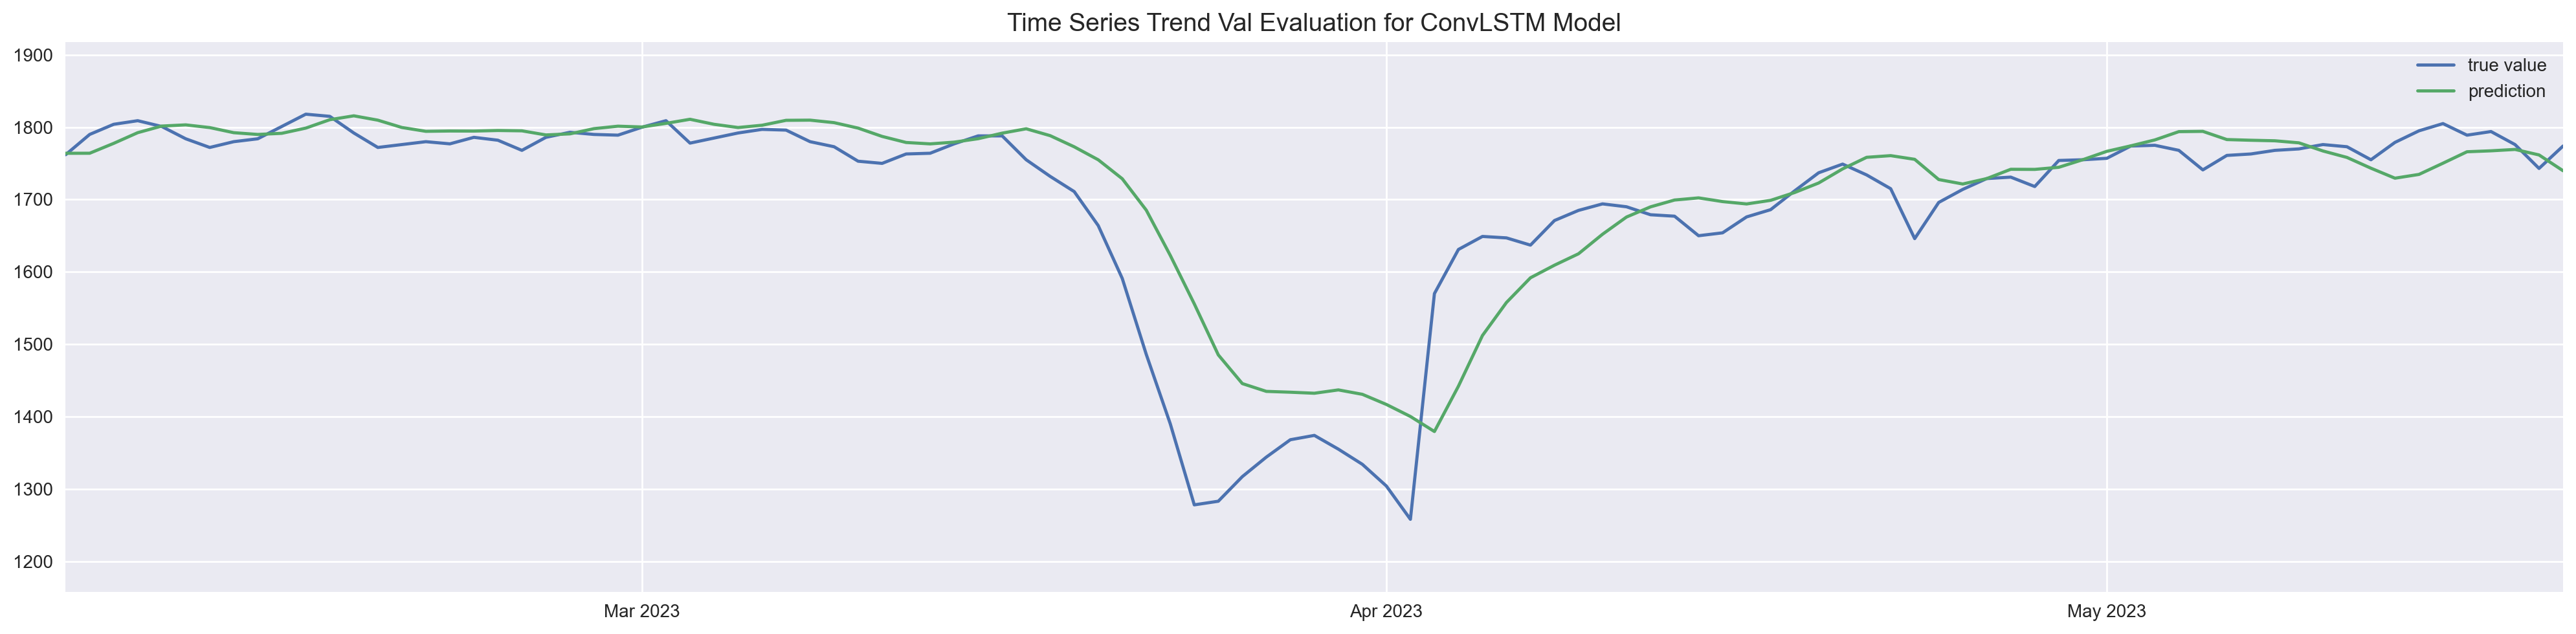

In [30]:
model_ConvLSTM_optimal = create_uncompiled_model_ConvLSTM()
model_ConvLSTM_optimal.load_weights(save_path_ConvLSTM+f'/model_weights_epoch_{310}.h5')

mae_val , mse_val , prediction_val = metric_calculator_val_test(model_ConvLSTM_optimal , x_val_univariate_forecast , scaler).values()
mae_test , mse_test , prediction_test = metric_calculator_val_test(model_ConvLSTM_optimal , x_test_univariate , scaler).values()

print(f"""
      Validation Results:
      mae = {mae_val},
      mse = {mse_val}
      
      Test Results:
      mae = {mae_test},
      mse = {mse_test}
      """)
plot_time_series(time_test, (x_test_univariate_inversed[G.WINDOW_SIZE:], prediction_test) , series_labels= ('true value' , 'prediction') , title = 'Test Evaluation for ConvLSTM Model')
plot_time_series(time_val[:-1], (x_val_univariate_forecast_inversed[G.WINDOW_SIZE:], prediction_val) , series_labels= ('true value' , 'prediction') , title = 'Val Evaluation for ConvLSTM Model')

# Prediction of 3 months ahead

In [31]:
# number of days to forecast
forecasting_days = 90

Saving Model

In [58]:
optimal_model = create_uncompiled_model_ConvLSTM()
optimal_model.load_weights(save_path_ConvLSTM+f'/model_weights_epoch_{310}.h5')
optimal_model.save_weights("2. Univariate TS Models" + f'/Optimal_Model.h5')

In [60]:
x_final = df.loc[:, 'ActiveCustomer'].to_numpy().reshape(-1,1)
x_final = scaler.transform(x_final).squeeze()

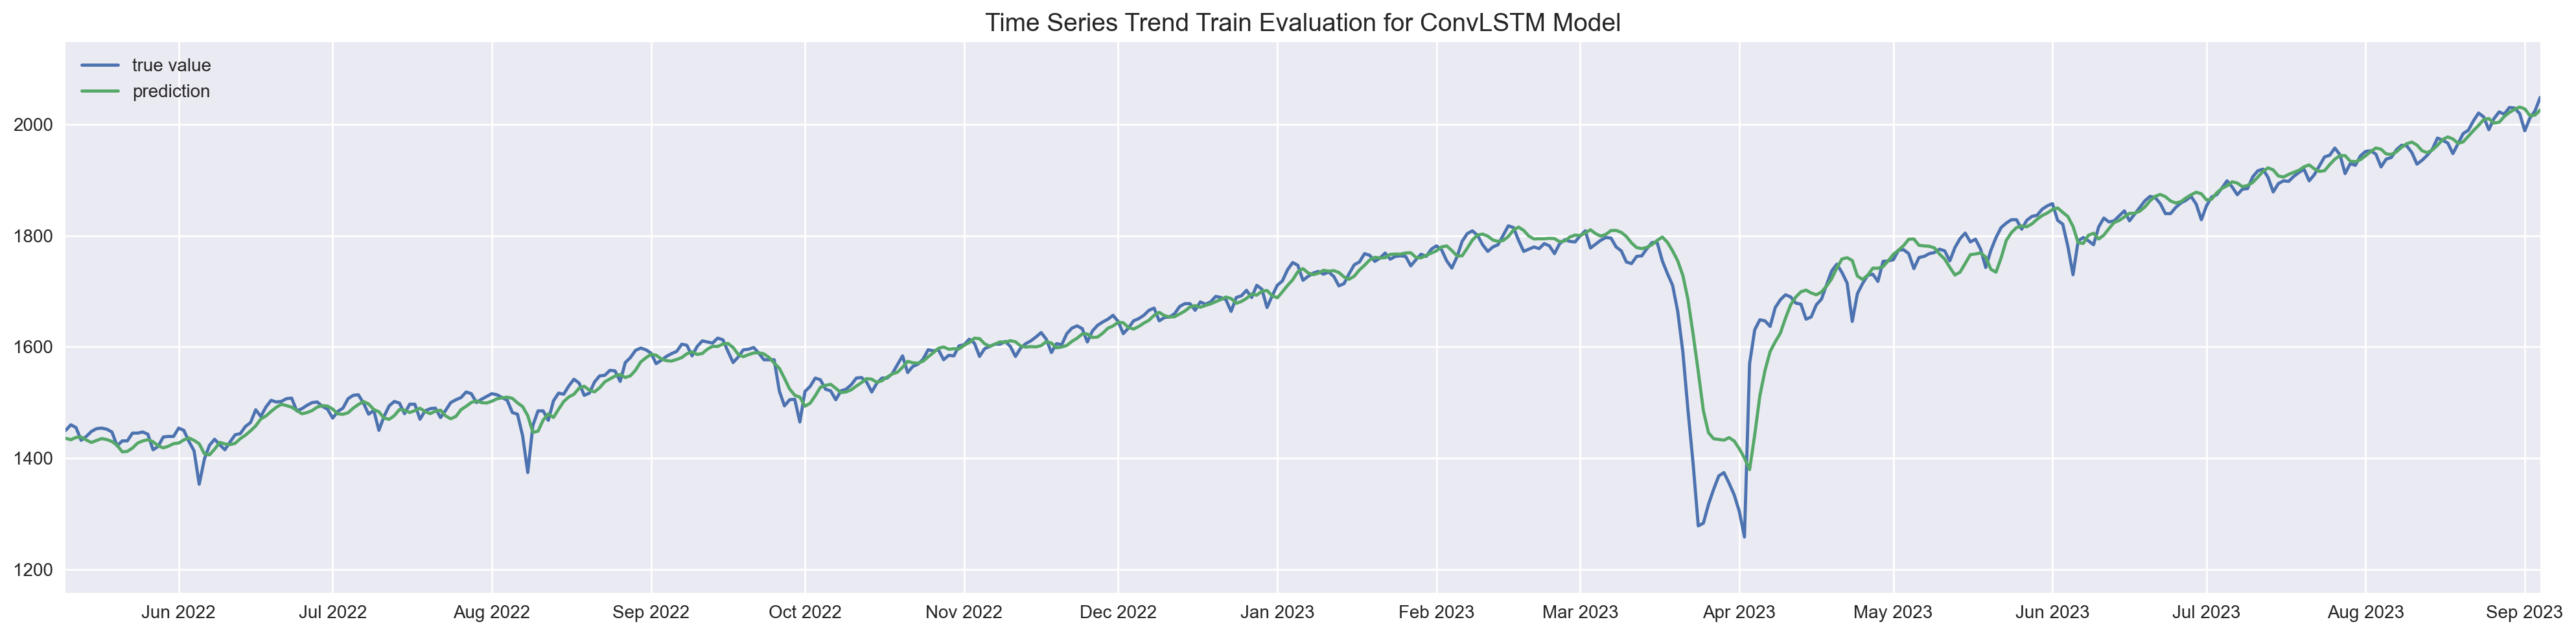

In [61]:
prediction_tr_optimal = scaler.inverse_transform(model_forecast(optimal_model, x_final[:-1])).squeeze()
plot_time_series(df.loc[G.WINDOW_SIZE: , 'Date'], ( df.loc[G.WINDOW_SIZE:, 'ActiveCustomer'], prediction_tr_optimal) , series_labels= ('true value' , 'prediction') , title = 'Train Evaluation for ConvLSTM Model')

In [69]:
from datetime import timedelta

forecast_df = pd.DataFrame(np.zeros((forecasting_days , 2)) , columns = ['Date' , 'Predicted_ActiveCustomer'])

def predict_one_step(model, input_data):
    input_data = np.array(input_data).reshape(1, G.WINDOW_SIZE, 1)
    prediction = model.predict(input_data)[0, 0]
    return prediction

# Initialize input_data with the last G.WINDOW_SIZE values from your historical data
input_data = list(x_final[-G.WINDOW_SIZE:])

# Generate a list of dates for the next 90 days
last_date = df['Date'].iloc[-1]
next_dates = [last_date + timedelta(days=i) for i in range(1, forecasting_days + 1)]
forecast_df['Date'] = next_dates
forecast_df.set_index('Date', inplace=True)

# Perform sequential forecasting for 90 days
for date in next_dates:
    # Predict one step ahead
    next_day_prediction = predict_one_step(optimal_model, input_data)
    
    # Append the predicted value and date to the DataFrame
    forecast_df.loc[date, 'Predicted_ActiveCustomer'] = next_day_prediction
    
    # Append the predicted value to the input data for the next prediction
    input_data.append(next_day_prediction)
    
    # Remove the oldest value to maintain the window size
    input_data.pop(0)

# Inverse transform the predicted values to the original scale
forecast_df['Predicted_ActiveCustomer'] = scaler.inverse_transform(np.array(forecast_df['Predicted_ActiveCustomer']).reshape(-1, 1)).squeeze()

forecast_df

Predicted_ActiveCustomer
Date                                
2023-09-05               2040.619767
2023-09-06               2046.024362
2023-09-07               2048.808754
2023-09-08               2048.676101
2023-09-09               2049.548546
...                              ...
2023-11-29               2302.459488
2023-11-30               2306.234644
2023-12-01               2309.924120
2023-12-02               2313.566843
2023-12-03               2317.249594

[90 rows x 1 columns]

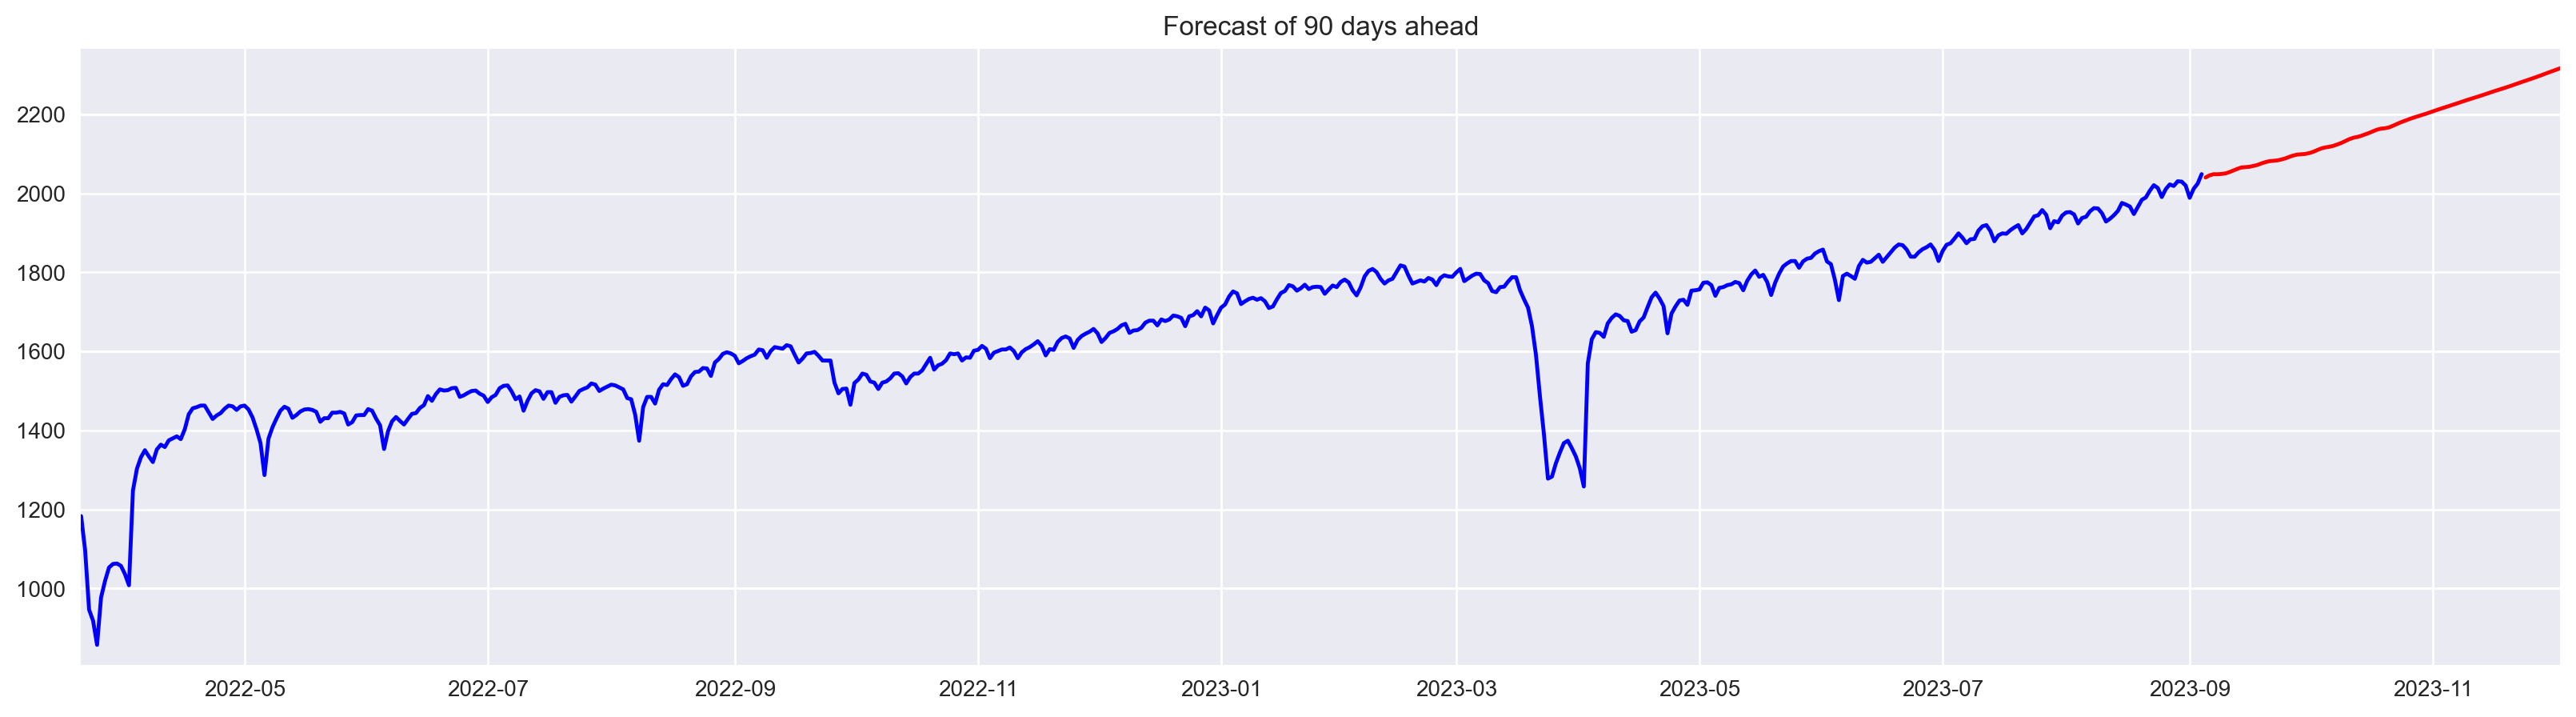

In [70]:
plt.style.use('seaborn')
plt.figure(figsize=(20, 5), dpi=200)
plt.plot(df['Date'], df['ActiveCustomer'] , color= 'blue')
plt.plot(forecast_df.index , forecast_df['Predicted_ActiveCustomer'] , color = 'red')

ymin = min(df['ActiveCustomer'].min() , forecast_df['Predicted_ActiveCustomer'].min())
ymax = max(df['ActiveCustomer'].max() , forecast_df['Predicted_ActiveCustomer'].max())
plt.ylim([ymin-50 , ymax+50])
plt.xlim([df.loc[0,'Date'] , forecast_df.index[-1]])

plt.title('Forecast of 90 days ahead')

plt.show()

Saving the Results

In [71]:
forecast_df = forecast_df.reset_index().rename(columns = {'Predicted_ActiveCustomer': 'ActiveCustomer'})
forecast_df['ActiveCustomer'] = np.around(forecast_df['ActiveCustomer'])
historical_and_forecast = pd.concat([df[['Date' , 'ActiveCustomer']] ,
                                     forecast_df])

In [72]:
excel_file_path = '2. Univariate TS Models/ModelPrediction.xlsx'
writer = pd.ExcelWriter(excel_file_path, engine='xlsxwriter')

historical_and_forecast.to_excel(writer, sheet_name='Historical + Forecast Data', index=False)
forecast_df.to_excel(writer, sheet_name='Forecast Data', index=False)

writer.save()

Saving the Scaler Function

In [75]:
import joblib
joblib.dump(scaler, '2. Univariate TS Models/min_max_scaler.pkl')

['2. Univariate TS Models/min_max_scaler.pkl']